In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from datetime import datetime # https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/discussion/97119

In [2]:
def mask2rle(img, width=1024, height=1024, max_color=1):
    rle = []
    lastColor = 0
    currentPixel = 0
    runStart = -1
    runLength = 0

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == max_color:
                    runStart = currentPixel
                    runLength = 1
                else:
                    rle.append(str(runStart))
                    rle.append(str(runLength))
                    runStart = -1
                    runLength = 0
                    currentPixel = 0
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor
            currentPixel+=1

    return " ".join(rle)

def rle2mask(rle, width=1024, height=1024, max_color=255):
    mask = np.zeros(width * height)
    """WARNING: This function should only be used in SIIM dataset because it constains .T() transformation here"""
    if rle == '-1': return mask.reshape(width, height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = max_color
        current_position += lengths[index]
    """WARNING: This function should only be used in SIIM dataset because it constains .T() transformation here"""
    return mask.reshape(width, height)

In [3]:
def draw(image, vmin=0, vmax=1):
    F = plt.figure()
    plt.imshow(np.squeeze(image), cmap='plasma', vmin=vmin, vmax=vmax)
    plt.grid(False)
def draw_gray(image, vmin=0, vmax=255):
    F = plt.figure()
    plt.imshow(np.squeeze(image), cmap='Greys', vmin=vmin, vmax=vmax)
    plt.grid(False)
def get_metadata_by_id(path):
    ds = pydicom.dcmread(path)
    return ds.PatientAge, ds.PatientSex, ds.PixelSpacing, ds.ReferringPhysicianName, ds.SeriesDescription, ds.ViewPosition
def get_load_image_by_id(path):
    ds = pydicom.read_file(path)
    return np.array(ds.pixel_array)
def get_time(ts): #1517875163.537053 -> 2018-02-05 23:59:23
    return datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

# Making Mixed Labels

In [4]:
PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/train-rle.csv"
NEW_PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/train-rle-mix.csv"
dataset = pd.read_csv(PATH)
dataset.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002 ...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 1...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 10...


In [6]:
dataset_dict = dict()
dataset_id = dataset['ImageId']
dataset_set = set(dataset_id.to_list())
print("Unique Size: {} Actual Size: {}".format(len(dataset_set), len(dataset_id)))
for id in dataset_set:
    dataset_dict[id] = dataset.loc[dataset_id == id]['EncodedPixels']
print("Unique dict() size: {}".format(len(dataset_dict)))

Unique Size: 10675 Actual Size: 11582
Unique dict() size: 10675


AssertionError: 

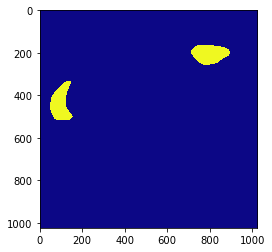

In [20]:
def get_mask_sum(encodes):
#     print("This has length: {}".format(length))
    masks = []
    for encode in encodes:
        mask = rle2mask(encode)
#         plt.imshow(mask)
        masks.append(mask)
#     print("Original Pixels: {}".format(np.array(masks).sum()/256))
    masks = (np.array(masks).sum(axis=0) > 0).astype(np.byte)
#     print("Transformed Pixels: {}".format(masks.sum()/1))
    
    """Testing if encode is correct"""
#     plt.imshow(masks)
#     plt.imshow(rle2mask(mask2rle(masks)))

    masks = mask2rle(masks)
    return masks
    
new_dataset = dict()
pbar = tqdm(dataset_dict.items())
for i, (id, encodes) in enumerate(pbar):
    encodes = encodes.to_list()
    length = len(encodes)
    mask = encodes
    if length > 1:
#         draw(rle2mask(mask[0]))
#         draw(rle2mask(mask[1]))
        mask = [get_mask_sum(mask)]
#         draw(rle2mask(mask[0]))
#         assert False
    assert len(mask) == 1
    new_dataset[i] = [id, mask[0]]

In [6]:
df = pd.DataFrame.from_dict(new_dataset, orient='index', columns=['ImageId', 'EncodedPixels'])
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.13726.15178752...,-1
1,1.2.276.0.7230010.3.1.4.8323329.14006.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.5587.151787518...,-1
3,1.2.276.0.7230010.3.1.4.8323329.1469.151787516...,-1
4,1.2.276.0.7230010.3.1.4.8323329.372.1517875162...,126496 27 992 37 982 52 968 61 961 73 949 88 9...


In [7]:
df.to_csv(NEW_PATH, index=False)

# Read `.dcm` File

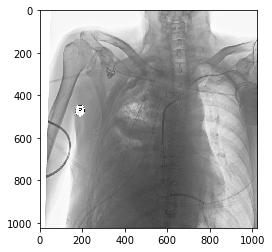

In [28]:
img_list = ["1.2.276.0.7230010.3.1.4.8323329.7020.1517875202.386064", "1.2.276.0.7230010.3.1.4.8323329.7013.1517875202.343274", "1.2.276.0.7230010.3.1.4.8323329.6491.1517875198.577052", "1.2.276.0.7230010.3.1.4.8323329.6370.1517875197.841736", "1.2.276.0.7230010.3.1.4.8323329.6082.1517875196.407031"]
# above is missing lines in sample_submission.csv. They seem to have some defects.

check = ["1.2.276.0.7230010.3.1.4.8323329.32476.1517875160.788542",
"1.2.276.0.7230010.3.1.4.8323329.32518.1517875160.978553",
"1.2.276.0.7230010.3.1.4.8323329.1344.1517875167.320441",
"1.2.276.0.7230010.3.1.4.8323329.1488.1517875168.67618",
"1.2.276.0.7230010.3.1.4.8323329.4569.1517875183.532479",
"1.2.276.0.7230010.3.1.4.8323329.6104.1517875196.561468",
"1.2.276.0.7230010.3.1.4.8323329.6275.1517875197.411005",
"1.2.276.0.7230010.3.1.4.8323329.6720.1517875199.820401",
"1.2.276.0.7230010.3.1.4.8323329.6882.1517875201.737674",
"1.2.276.0.7230010.3.1.4.8323329.10149.1517875222.359705",
"1.2.276.0.7230010.3.1.4.8323329.11431.1517875232.910638",
"1.2.276.0.7230010.3.1.4.8323329.11512.1517875233.270680",
"1.2.276.0.7230010.3.1.4.8323329.12131.1517875237.586703",
"1.2.276.0.7230010.3.1.4.8323329.13162.1517875243.950980",
"1.2.276.0.7230010.3.1.4.8323329.13425.1517875245.261740",
"1.2.276.0.7230010.3.1.4.8323329.14474.1517875252.269239",]
check = "1.2.276.0.7230010.3.1.4.8323329.11354.1517875232.557775"

IMG_PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/siim-original/"
# IMG_PATH = IMG_PATH + "dicom-images-test/{}.dcm".format(img_list[4])
IMG_PATH = IMG_PATH + "dicom-images-train/{}.dcm".format(check)
# IMG_PATH = IMG_PATH + "dicom-images-test/1.2.276.0.7230010.3.1.4.8323329.7046.1517875202.494784.dcm"
img = get_load_image_by_id(IMG_PATH)
draw_gray(img)

In [26]:
img_list = ["1.2.276.0.7230010.3.1.4.8323329.7020.1517875202.386064", "1.2.276.0.7230010.3.1.4.8323329.7013.1517875202.343274", "1.2.276.0.7230010.3.1.4.8323329.6491.1517875198.577052", "1.2.276.0.7230010.3.1.4.8323329.6370.1517875197.841736", "1.2.276.0.7230010.3.1.4.8323329.6082.1517875196.407031"]
# above is missing lines in sample_submission.csv. They seem to have some defects.

check = ["1.2.276.0.7230010.3.1.4.8323329.32476.1517875160.788542",
"1.2.276.0.7230010.3.1.4.8323329.32518.1517875160.978553",
"1.2.276.0.7230010.3.1.4.8323329.1344.1517875167.320441",
"1.2.276.0.7230010.3.1.4.8323329.1488.1517875168.67618",
"1.2.276.0.7230010.3.1.4.8323329.4569.1517875183.532479",
"1.2.276.0.7230010.3.1.4.8323329.6104.1517875196.561468",
"1.2.276.0.7230010.3.1.4.8323329.6275.1517875197.411005",
"1.2.276.0.7230010.3.1.4.8323329.6720.1517875199.820401",
"1.2.276.0.7230010.3.1.4.8323329.6882.1517875201.737674",
"1.2.276.0.7230010.3.1.4.8323329.10149.1517875222.359705",
"1.2.276.0.7230010.3.1.4.8323329.11431.1517875232.910638",
"1.2.276.0.7230010.3.1.4.8323329.11512.1517875233.270680",
"1.2.276.0.7230010.3.1.4.8323329.12131.1517875237.586703",
"1.2.276.0.7230010.3.1.4.8323329.13162.1517875243.950980",
"1.2.276.0.7230010.3.1.4.8323329.13425.1517875245.261740",
"1.2.276.0.7230010.3.1.4.8323329.14474.1517875252.269239",]
check = "1.2.276.0.7230010.3.1.4.8323329.11424.1517875232.878433"

IMG_PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/siim-original/"
# IMG_PATH = IMG_PATH + "dicom-images-test/{}.dcm".format(img_list[4])
IMG_PATH = IMG_PATH + "dicom-images-train/{}.dcm".format(check)
# IMG_PATH = IMG_PATH + "dicom-images-test/1.2.276.0.7230010.3.1.4.8323329.7046.1517875202.494784.dcm"
img = get_load_image_by_id(IMG_PATH)
draw_gray(img)

FileNotFoundError: [Errno 2] No such file or directory: '/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/siim-original/dicom-images-train/1.2.276.0.7230010.3.1.4.8323329.7020.1517875202.386064.dcm'

# Adding Metadata & Saving to `.npy` - Train

In [14]:
SAVE = False
IMG_PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/siim-original/dicom-images-train"
PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/train-rle-mix.csv"
NEW_PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/train-rle-mix-added.csv"
dataset = pd.read_csv(PATH)
dataset.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.13726.15178752...,-1
1,1.2.276.0.7230010.3.1.4.8323329.14006.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.5587.151787518...,-1
3,1.2.276.0.7230010.3.1.4.8323329.1469.151787516...,-1
4,1.2.276.0.7230010.3.1.4.8323329.372.1517875162...,126496 27 992 37 982 52 968 61 961 73 949 88 9...


In [10]:
for id in dataset['ImageId'].to_list():
    print(dataset.loc[dataset['ImageId'] == id].to_dict())
    break

{'ImageId': {0: '1.2.276.0.7230010.3.1.4.8323329.13726.1517875247.412197.dcm'}, 'EncodedPixels': {0: '-1'}}


In [15]:
# imageid = []
# encodedpixels = []
# PatientAge = []
# PatientSex = []
# PixelSpacing = []
# ReferringPhysicianName = []
# SeriesDescription = []
# ViewPosition = []

new_dataset = dict()
num_saved = 0

pbar = tqdm(dataset.iterrows())
for i, (index, row) in enumerate(pbar):
#     imageid.append(row['ImageId'])
#     encodedpixels.append(row['EncodedPixels'])
    path = os.path.join(IMG_PATH, row['ImageId'])
    a,b,c,d,e,f = get_metadata_by_id(path)
    
    save_path = path.replace(".dcm", ".npy")
    if SAVE and not os.path.isfile(save_path):
        np.save(save_path, get_load_image_by_id(path))
        num_saved = num_saved + 1
    pbar.set_description("num_saved = {}".format(num_saved))
    
#     PatientAge.append(a)
#     PatientSex.append(b)
#     PixelSpacing.append(c)
#     ReferringPhysicianName.append(d)
#     SeriesDescription.append(e)
#     ViewPosition.append(f)
    if SAVE:
        new_dataset[i] = [row['ImageId'].replace(".dcm", ".npy"), row['EncodedPixels'], a,b,c,d,e,f]
    else:
        new_dataset[i] = [row['ImageId'], row['EncodedPixels'], a,b,c,d,e,f]


In [16]:
df = pd.DataFrame.from_dict(new_dataset, orient='index', columns=['ImageId', 'EncodedPixels', 'PatientAge', 'PatientSex', 'PixelSpacing', 'ReferringPhysicianName', 'SeriesDescription', 'ViewPosition'])
df.head()

,ImageId,EncodedPixels,PatientAge,PatientSex,PixelSpacing,ReferringPhysicianName,SeriesDescription,ViewPosition
0,1.2.276.0.7230010.3.1.4.8323329.13726.15178752...,-1,69,M,"[0.14300000000000002, 0.14300000000000002]",,view: PA,PA
1,1.2.276.0.7230010.3.1.4.8323329.14006.15178752...,-1,46,F,"[0.168, 0.168]",,view: AP,AP
2,1.2.276.0.7230010.3.1.4.8323329.5587.151787518...,-1,54,F,"[0.14300000000000002, 0.14300000000000002]",,view: PA,PA
3,1.2.276.0.7230010.3.1.4.8323329.1469.151787516...,-1,48,F,"[0.168, 0.168]",,view: AP,AP
4,1.2.276.0.7230010.3.1.4.8323329.372.1517875162...,126496 27 992 37 982 52 968 61 961 73 949 88 9...,34,M,"[0.19431099999999998, 0.19431099999999998]",,view: PA,PA


In [17]:
df.to_csv(NEW_PATH, index=False)

# Adding Metadata & Saving to `.npy` - Test

In [4]:
SAVE = False
IMG_PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/siim-original/dicom-images-test"
PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/sample_submission.csv"
NEW_PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/sample_submission-added.csv"
dataset = pd.read_csv(PATH)
dataset.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6567.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6170.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6346.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6890.151787520...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6400.151787519...,-1


In [5]:
# imageid = []
# encodedpixels = []
# PatientAge = []
# PatientSex = []
# PixelSpacing = []
# ReferringPhysicianName = []
# SeriesDescription = []
# ViewPosition = []

new_dataset = dict()
num_saved = 0

pbar = tqdm(dataset.iterrows())
for i, (index, row) in enumerate(pbar):
#     imageid.append(row['ImageId'])
#     encodedpixels.append(row['EncodedPixels'])
    path = os.path.join(IMG_PATH, row['ImageId'] + ".dcm")
    a,b,c,d,e,f = get_metadata_by_id(path)
    
    save_path = path.replace(".dcm", ".npy")
    if SAVE and not os.path.isfile(save_path):
        np.save(save_path, get_load_image_by_id(path))
        num_saved = num_saved + 1
    pbar.set_description("num_saved = {}".format(num_saved))
    
#     PatientAge.append(a)
#     PatientSex.append(b)
#     PixelSpacing.append(c)
#     ReferringPhysicianName.append(d)
#     SeriesDescription.append(e)
#     ViewPosition.append(f)
    if SAVE:
        new_dataset[i] = [row['ImageId'].replace(".dcm", ".npy"), row['EncodedPixels'], a,b,c,d,e,f]
    else:
        new_dataset[i] = [row['ImageId'], row['EncodedPixels'], a,b,c,d,e,f]


In [6]:
df = pd.DataFrame.from_dict(new_dataset, orient='index', columns=['ImageId', 'EncodedPixels', 'PatientAge', 'PatientSex', 'PixelSpacing', 'ReferringPhysicianName', 'SeriesDescription', 'ViewPosition'])
df.head()

,ImageId,EncodedPixels,PatientAge,PatientSex,PixelSpacing,ReferringPhysicianName,SeriesDescription,ViewPosition
0,1.2.276.0.7230010.3.1.4.8323329.6567.151787519...,-1,80,F,"[0.168, 0.168]",,view: AP,AP
1,1.2.276.0.7230010.3.1.4.8323329.6170.151787519...,-1,62,F,"[0.139, 0.139]",,view: PA,PA
2,1.2.276.0.7230010.3.1.4.8323329.6346.151787519...,-1,30,F,"[0.19431099999999998, 0.19431099999999998]",,view: PA,PA
3,1.2.276.0.7230010.3.1.4.8323329.6890.151787520...,-1,49,F,"[0.14300000000000002, 0.14300000000000002]",,view: PA,PA
4,1.2.276.0.7230010.3.1.4.8323329.6400.151787519...,-1,65,F,"[0.14300000000000002, 0.14300000000000002]",,view: PA,PA


In [7]:
df.to_csv(NEW_PATH, index=False)

# Leakage - Old Sample Submission

In [59]:
PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/old_sample_submission.csv"
NEW_PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/old_sample_submission_dupe.csv"
dataset = pd.read_csv(PATH)
dataset.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.9488.151787521...,-1
1,1.2.276.0.7230010.3.1.4.8323329.7388.151787520...,-1
2,1.2.276.0.7230010.3.1.4.8323329.8104.151787520...,-1
3,1.2.276.0.7230010.3.1.4.8323329.952.1517875165...,-1
4,1.2.276.0.7230010.3.1.4.8323329.680.1517875164...,-1


In [60]:
dic = dict()

# count each appearance
for id in dataset['ImageId'].tolist():
    if id not in dic.keys():
        dic[id] = 1
    else:
        dic[id] = dic[id] + 1

# classify each appearance
appear = dict()
for id, appearance in dic.items():
    if dic[id] not in appear.keys():
        appear[dic[id]] = [id]
    else:
        appear[dic[id]].append(id)

print(appear) # we know that multiple appearance is not empty

{1: ['1.2.276.0.7230010.3.1.4.8323329.9488.1517875218.175563', '1.2.276.0.7230010.3.1.4.8323329.7388.1517875204.201431', '1.2.276.0.7230010.3.1.4.8323329.8104.1517875209.54822', '1.2.276.0.7230010.3.1.4.8323329.952.1517875165.756716', '1.2.276.0.7230010.3.1.4.8323329.680.1517875164.49743', '1.2.276.0.7230010.3.1.4.8323329.586.1517875163.569244', '1.2.276.0.7230010.3.1.4.8323329.7050.1517875202.507168', '1.2.276.0.7230010.3.1.4.8323329.600.1517875163.632969', '1.2.276.0.7230010.3.1.4.8323329.8303.1517875210.164933', '1.2.276.0.7230010.3.1.4.8323329.6707.1517875199.622316', '1.2.276.0.7230010.3.1.4.8323329.9338.1517875217.483777', '1.2.276.0.7230010.3.1.4.8323329.6652.1517875199.400704', '1.2.276.0.7230010.3.1.4.8323329.8599.1517875212.789106', '1.2.276.0.7230010.3.1.4.8323329.8129.1517875209.182736', '1.2.276.0.7230010.3.1.4.8323329.6115.1517875196.616758', '1.2.276.0.7230010.3.1.4.8323329.6682.1517875199.532073', '1.2.276.0.7230010.3.1.4.8323329.8507.1517875212.328410', '1.2.276.0.7230

In [61]:
l = []
for key, item in appear.items():
    if key != 1:
        l = l + item
print("There are {} images we can use in the test set.".format(len(l)))

new_dataset = dict()
for i, id in enumerate(l):
    new_dataset[i] = [id, "Non-Empty"]

There are 248 images we can use in the test set.


In [62]:
df = pd.DataFrame.from_dict(new_dataset, orient='index', columns=['ImageId', 'EncodedPixels'])
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.828.1517875165...,Non-Empty
1,1.2.276.0.7230010.3.1.4.8323329.9840.151787522...,Non-Empty
2,1.2.276.0.7230010.3.1.4.8323329.841.1517875165...,Non-Empty
3,1.2.276.0.7230010.3.1.4.8323329.5803.151787519...,Non-Empty
4,1.2.276.0.7230010.3.1.4.8323329.6797.151787520...,Non-Empty


In [63]:
df.to_csv(NEW_PATH, index=False)

# Leakage - Sample Submission

In [29]:
PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/sample_submission.csv"
NEW_PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/submission_leakage_dupe.csv"
dataset = pd.read_csv(PATH)
dataset.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6567.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6170.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6346.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6890.151787520...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6400.151787519...,-1


In [30]:
dic = dict()

# count each appearance
for id in dataset['ImageId'].tolist():
    if id not in dic.keys():
        dic[id] = 1
    else:
        dic[id] = dic[id] + 1

# classify each appearance
appear = dict()
for id, appearance in dic.items():
    if dic[id] not in appear.keys():
        appear[dic[id]] = [id]
    else:
        appear[dic[id]].append(id)

print(appear) # we know that multiple appearance is not empty

{1: ['1.2.276.0.7230010.3.1.4.8323329.6567.1517875198.951391', '1.2.276.0.7230010.3.1.4.8323329.6170.1517875196.850168', '1.2.276.0.7230010.3.1.4.8323329.6346.1517875197.726308', '1.2.276.0.7230010.3.1.4.8323329.6890.1517875201.786808', '1.2.276.0.7230010.3.1.4.8323329.6400.1517875197.975358', '1.2.276.0.7230010.3.1.4.8323329.6000.1517875193.775354', '1.2.276.0.7230010.3.1.4.8323329.5943.1517875192.988544', '1.2.276.0.7230010.3.1.4.8323329.582.1517875163.546454', '1.2.276.0.7230010.3.1.4.8323329.6518.1517875198.700842', '1.2.276.0.7230010.3.1.4.8323329.6878.1517875201.691288', '1.2.276.0.7230010.3.1.4.8323329.6428.1517875198.134029', '1.2.276.0.7230010.3.1.4.8323329.6098.1517875196.532890', '1.2.276.0.7230010.3.1.4.8323329.6444.1517875198.259517', '1.2.276.0.7230010.3.1.4.8323329.5872.1517875192.6373', '1.2.276.0.7230010.3.1.4.8323329.6251.1517875197.309237', '1.2.276.0.7230010.3.1.4.8323329.6544.1517875198.824207', '1.2.276.0.7230010.3.1.4.8323329.6809.1517875201.284225', '1.2.276.0.7

In [31]:
l = []
for key, item in appear.items():
    if key != 1:
        l = l + item
print("There are {} images we can use in the test set.".format(len(l)))

new_dataset = dict()
for i, id in enumerate(l):
    new_dataset[i] = [id, "Non-Empty"]

There are 78 images we can use in the test set.


In [32]:
df = pd.DataFrame.from_dict(new_dataset, orient='index', columns=['ImageId', 'EncodedPixels'])
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.679.1517875164...,Non-Empty
1,1.2.276.0.7230010.3.1.4.8323329.6205.151787519...,Non-Empty
2,1.2.276.0.7230010.3.1.4.8323329.6767.151787520...,Non-Empty
3,1.2.276.0.7230010.3.1.4.8323329.6315.151787519...,Non-Empty
4,1.2.276.0.7230010.3.1.4.8323329.6300.151787519...,Non-Empty


In [33]:
df.to_csv(NEW_PATH, index=False)

# Leakage - Train

In [38]:
PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/train-rle.csv"
NEW_PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/train-rle_dupe.csv"
dataset = pd.read_csv(PATH)
dataset.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002 ...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 1...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 10...


In [39]:
dic = dict()

# count each appearance
for id in dataset['ImageId'].tolist():
    if id not in dic.keys():
        dic[id] = 1
    else:
        dic[id] = dic[id] + 1

# classify each appearance
appear = dict()
for id, appearance in dic.items():
    if dic[id] not in appear.keys():
        appear[dic[id]] = [id]
    else:
        appear[dic[id]].append(id)

print(appear) # we know that multiple appearance is not empty

{1: ['1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090.dcm', '1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137.dcm', '1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709.dcm', '1.2.276.0.7230010.3.1.4.8323329.1314.1517875167.222290.dcm', '1.2.276.0.7230010.3.1.4.8323329.11364.1517875232.606684.dcm', '1.2.276.0.7230010.3.1.4.8323329.4541.1517875183.370160.dcm', '1.2.276.0.7230010.3.1.4.8323329.4440.1517875182.865105.dcm', '1.2.276.0.7230010.3.1.4.8323329.4982.1517875185.837576.dcm', '1.2.276.0.7230010.3.1.4.8323329.31759.1517875156.671103.dcm', '1.2.276.0.7230010.3.1.4.8323329.12743.1517875241.599591.dcm', '1.2.276.0.7230010.3.1.4.8323329.11633.1517875234.21969.dcm', '1.2.276.0.7230010.3.1.4.8323329.11512.1517875233.270680.dcm', '1.2.276.0.7230010.3.1.4.8323329.2663.1517875173.932279.dcm', '1.2.276.0.7230010.3.1.4.8323329.10206.1517875222.624433.dcm', '1.2.276.0.7230010.3.1.4.8323329.5782.1517875190.531042.dcm', '1.2.276.0.7230010.3.1.4.8323329.3058.1517875175.831767.dcm

In [40]:
l = []
for key, item in appear.items():
    if key != 1:
        l = l + item
print("There are {} images we can use in the test set.".format(len(l)))

new_dataset = dict()
for i, id in enumerate(l):
    new_dataset[i] = [id, "Non-Empty"]

There are 624 images we can use in the test set.


In [41]:
df = pd.DataFrame.from_dict(new_dataset, orient='index', columns=['ImageId', 'EncodedPixels'])
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,Non-Empty
1,1.2.276.0.7230010.3.1.4.8323329.14508.15178752...,Non-Empty
2,1.2.276.0.7230010.3.1.4.8323329.3889.151787517...,Non-Empty
3,1.2.276.0.7230010.3.1.4.8323329.1695.151787516...,Non-Empty
4,1.2.276.0.7230010.3.1.4.8323329.11680.15178752...,Non-Empty


In [42]:
df.to_csv(NEW_PATH, index=False)

# Left and Right Correlation

In [2]:
PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/train-rle.csv"
dataset = pd.read_csv(PATH)
dataset.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002 ...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 1...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 10...


## Left Right Difference in Shape

In [36]:
encodeds = dataset["EncodedPixels"].tolist()
pbar = tqdm(encodeds)
n = len(pbar)
m = np.zeros((1024, 1024))
for encoded in pbar:
    mask = rle2mask(encoded)
    if mask.sum() != 0:
        mask = np.transpose(mask)
        m = m + mask
m_absolute = (m > 0).astype(np.byte)

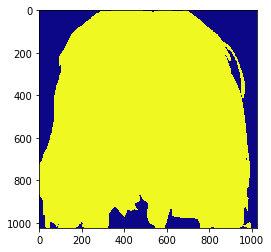

In [37]:
draw(m_absolute)

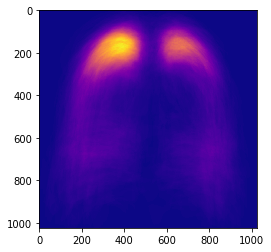

In [52]:
draw(m, m.min(), m.max())

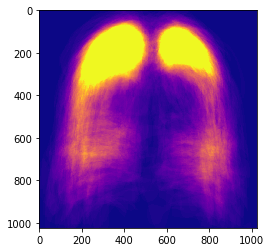

In [56]:
draw(m, m.min(), m.min()+255*100)

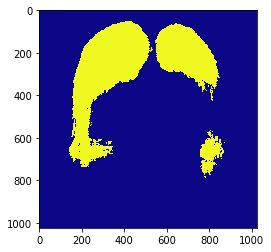

In [46]:
draw((m > 255*50).astype(np.byte))

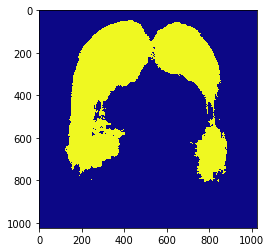

In [57]:
draw((m > 255*40).astype(np.byte))

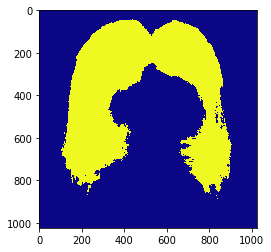

In [58]:
draw((m > 255*30).astype(np.byte))

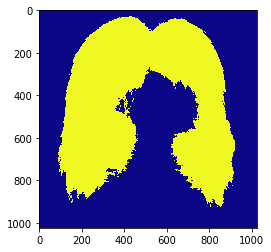

In [55]:
draw((m > 255*20).astype(np.byte))

## Left Right Difference in Probability

In [23]:
left_only_total = 0
right_only_total = 0
left_right_total = 0
empty = 0

encodeds = dataset["EncodedPixels"].tolist()
pbar = tqdm(encodeds)
for encoded in pbar:
    mask = rle2mask(encoded)
    mask = np.transpose(mask)
    if mask.sum() != 0:
        mask_left = mask[:,:512]
        mask_right = mask[:,513:]
        if mask_left.sum() != 0 and mask_right.sum() != 0:
            left_right_total = left_right_total + 1
            continue
        else:
            if mask_left.sum() != 0 and mask_right.sum() == 0:
                left_only_total = left_only_total + 1
                continue
            if mask_left.sum() == 0 and mask_right.sum() != 0:
                right_only_total = right_only_total + 1
                continue
    else:
        empty = empty +1
        continue
print("There are {} left, {} right, {} combined, {} empty".format(left_only_total, right_only_total, left_right_total, empty))


There are 1756 left, 1336 right, 194 combined, 8296 empty


In [28]:
total = left_only_total + right_only_total + left_right_total + empty
print("The chance of having left is {}".format(left_only_total/total))
print("The chance of having right is {}".format(right_only_total/total))
print("Thereotical chance of having combined is {}".format((right_only_total/total)*(left_only_total/total)))
print("Actual chance of having combined is {}".format(left_right_total/total))
print("There is a difference of {} case out of {} case".format(total * ((right_only_total/total)*(left_only_total/total)) - (left_right_total/total), total))

The chance of having left is 0.15161457433949233
The chance of having right is 0.11535140735624244
Thereotical chance of having combined is 0.017488954525778082
Actual chance of having combined is 0.016750129511310656
There is a difference of 202.54032118805043 case out of 11582 case


In [31]:
left_only_total = 0
right_only_total = 0
left_right_total = 0
empty = 0

encodeds = dataset["EncodedPixels"].tolist()[:int(11582/2)]
pbar = tqdm(encodeds)
for encoded in pbar:
    mask = rle2mask(encoded)
    mask = np.transpose(mask)
    if mask.sum() != 0:
        mask_left = mask[:,:512]
        mask_right = mask[:,513:]
        if mask_left.sum() != 0 and mask_right.sum() != 0:
            left_right_total = left_right_total + 1
            continue
        else:
            if mask_left.sum() != 0 and mask_right.sum() == 0:
                left_only_total = left_only_total + 1
                continue
            if mask_left.sum() == 0 and mask_right.sum() != 0:
                right_only_total = right_only_total + 1
                continue
    else:
        empty = empty +1
        continue
print("There are {} left, {} right, {} combined, {} empty".format(left_only_total, right_only_total, left_right_total, empty))


There are 1655 left, 1260 right, 191 combined, 2685 empty


In [32]:
total = left_only_total + right_only_total + left_right_total + empty
print("The chance of having left is {}".format(left_only_total/total))
print("The chance of having right is {}".format(right_only_total/total))
print("Thereotical chance of having combined is {}".format((right_only_total/total)*(left_only_total/total)))
print("Actual chance of having combined is {}".format(left_right_total/total))
print("There is a difference of {} case out of {} case".format(total * ((right_only_total/total)*(left_only_total/total)) - (left_right_total/total), total))

The chance of having left is 0.28578829217751683
The chance of having right is 0.21757900189949922
Thereotical chance of having combined is 0.062181531366546576
Actual chance of having combined is 0.032982213780003454
There is a difference of 360.0602659298912 case out of 5791 case


So we can clearly see that left and right are independent, or even negatively dependent. That is very strange. Also note that the chance of having the disease on the left chest is much higher.  

It seems like AP and PA all have correct orientation of left chest or right chest.  
So, new augmentation includes:
 - erase half
 - cut paste half

# Reverse Mask Postprocess

In [20]:
PATH = "/home/koke_cacao/Downloads/f1be1364-CP59_F[0]_PTsiimv132_VTf1be1364_LR0.00015_BS6_IMG512.pth-25540f7d-F0-T0.99-Prob-TTA0.csv"
NEW_PATH = "/home/koke_cacao/Downloads/f1be1364-CP59_F[0]_PTsiimv132_VTf1be1364_LR0.00015_BS6_IMG512.pth-25540f7d-F0-T0.99-Prob-TTA0-Inverse.csv"
dataset = pd.read_csv(PATH)
dataset.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5879.151787519...,899629 2 1021 4 1017 14 1009 16 1007 18 1005 2...
1,1.2.276.0.7230010.3.1.4.8323329.5879.151787519...,895529 8 1015 10 1013 12 1011 14 1010 14 1010 ...
2,1.2.276.0.7230010.3.1.4.8323329.5879.151787519...,893481 12 1011 14 1007 18 1005 20 1003 22 1001...
3,1.2.276.0.7230010.3.1.4.8323329.6294.151787519...,83784 1 7 1 1013 12 1004 1 7 13 1001 24 1000 2...
4,1.2.276.0.7230010.3.1.4.8323329.6105.151787519...,827626 1 1022 3 1020 4 1020 4 1021 4 1021 4 10...


In [21]:
dataset_dict = dict()
dataset_encodes = dataset['EncodedPixels'].tolist()
dataset_id = dataset['ImageId'].tolist()

new_dataset = dict()
pbar = tqdm(zip(dataset_id, dataset_encodes))
for i, (id, encode) in enumerate(pbar):
    if str(encode) == "nan":
        new_dataset[i] = [id, "-1"]
        continue
    encode = mask2rle(np.transpose(rle2mask(encode, max_color=1)), max_color=1)
    new_dataset[i] = [id, encode]

In [22]:
df = pd.DataFrame.from_dict(new_dataset, orient='index', columns=['ImageId', 'EncodedPixels'])
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5879.151787519...,559993 5 1018 7 1016 9 1014 10 1011 13 1010 15...
1,1.2.276.0.7230010.3.1.4.8323329.5879.151787519...,527233 5 1018 7 1016 9 1014 11 1012 13 1010 15...
2,1.2.276.0.7230010.3.1.4.8323329.5879.151787519...,529281 7 1016 8 1015 9 1014 11 1013 12 1012 12...
3,1.2.276.0.7230010.3.1.4.8323329.6294.151787519...,172382 18 1005 20 977 54 969 56 961 68 955 70 ...
4,1.2.276.0.7230010.3.1.4.8323329.6105.151787519...,238378 2 1021 4 1019 10 1015 10 1017 10 1015 1...


In [23]:
df.to_csv(NEW_PATH, index=False)

# Overall File

In [103]:
TEST_IMG = None
TRAIN_IMG = None
TRAIN_RLE = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/train-rle.csv"
TRAIN_RLE_MIX = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/train-rle-mix.csv"
SUMBISSION_LEAKAGE_DUEP = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/submission_leakage_dupe.csv"
SAMPLE_SUBMISSION = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/sample_submission.csv"
KAGGLE_TO_NIH_ID = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/kaggle_to_nih_id.csv"
NEW_PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/siim_dataset.csv"

dataset = pd.read_csv(KAGGLE_TO_NIH_ID)
dataset.head()

,Kaggle_ID,NIH_ID
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,00028864_007.png
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,00015606_016.png
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,00018865_006.png
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,00011831_006.png
4,1.2.276.0.7230010.3.1.4.8323329.1314.151787516...,00011460_024.png


In [104]:
dataset_dict = dict()
dataset_id = dataset['Kaggle_ID'].tolist()
dataset_nih = dataset['NIH_ID'].tolist()
dataset_patient = [i.split("_")[0] for i in dataset_nih]

In [105]:
dataset_test = []
dataset_rle = []
dataset_label = []

sample_submission = pd.read_csv(SAMPLE_SUBMISSION)['ImageId'].tolist()
train_rle_mix = pd.read_csv(TRAIN_RLE_MIX)
submission_leakage_dupe = pd.read_csv(SUMBISSION_LEAKAGE_DUEP)['ImageId'].tolist()

train_rle = [w.replace(".dcm", "") for w in pd.read_csv(TRAIN_RLE)['ImageId'].tolist()]
for i in tqdm(dataset_id):
    assert not (i in sample_submission and i in train_rle)
    assert i in sample_submission or i in train_rle
    if i in sample_submission:
        dataset_test.append('test')
        if i in submission_leakage_dupe:
            dataset_rle.append("Non-Empty")
            dataset_label.append("1")
        else:
            dataset_rle.append("Predict")
            dataset_label.append("Predict")
    if i in train_rle:
        dataset_test.append('train')
        _ = str(train_rle_mix.loc[train_rle_mix['ImageId'] == i+".dcm"]["EncodedPixels"].tolist()[0])
        dataset_rle.append(_)
        if _ == "-1": dataset_label.append("0")
        else: dataset_label.append("1")

assert len(dataset_test) == len(dataset_nih)
assert len(dataset_rle) == len(dataset_nih)
assert len(dataset_label) == len(dataset_nih)

In [106]:
dataset_time = []
dataset_time_float = []

for i in tqdm(dataset_id):
    i = i.split('.')
    i = i[-2] + '.' + i[-1]
    i = float(i)
    dataset_time_float.append(format(i, 'f'))
    i = get_time(i)
    dataset_time.append(i)

assert len(dataset_time) == len(dataset_nih)
assert len(dataset_time_float) == len(dataset_nih)

In [107]:
new_dataset = dict()
pbar = tqdm(zip(dataset_id, dataset_nih, dataset_patient, dataset_test, dataset_rle, dataset_label, dataset_time, dataset_time_float))
for i, (id, nih, patient, test, rle, label, time, time_float) in enumerate(pbar):
    new_dataset[i] = [id, nih, patient, test, rle, label, time, time_float]

In [108]:
df = pd.DataFrame.from_dict(new_dataset, orient='index', columns=['ImageId', 'NIHId', 'PatientId', 'Test', 'Rle', 'Label', 'Time', 'TimeFloat'])
df.head()

,ImageId,NIHId,PatientId,Test,Rle,Label,Time,TimeFloat
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,00028864_007.png,00028864,train,-1,0,2018-02-05 23:59:48,1517875188.959090
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,00015606_016.png,00015606,train,-1,0,2018-02-06 00:00:39,1517875239.501137
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,00018865_006.png,00018865,train,175349 7 1013 12 1009 17 1005 19 1003 20 1002 ...,1,2018-02-05 23:59:45,1517875185.355709
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,00011831_006.png,00011831,train,162376 12 1007 18 1003 22 999 26 996 28 993 30...,1,2018-02-05 23:59:21,1517875161.299312
4,1.2.276.0.7230010.3.1.4.8323329.1314.151787516...,00011460_024.png,00011460,train,119331 47 972 82 937 107 912 122 897 137 882 1...,1,2018-02-05 23:59:27,1517875167.222290


In [109]:
df.to_csv(NEW_PATH, index=False)

# Concat Prediction into Overall File

In [24]:
PREDICTION_PATH = "/home/koke_cacao/Downloads/three_stage_fusionv1.csv"
OLD_PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/siim_dataset.csv"
NEW_PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/siim_dataset+submission.csv"

df = pd.concat([pd.read_csv(OLD_PATH).set_index("ImageId"), pd.read_csv(PREDICTION_PATH).set_index("ImageId")], axis=1, sort=False)
df.head()

,NIHId,PatientId,Test,Rle,Label,Time,TimeFloat,EncodedPixels
1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090,00028864_007.png,28864.0,train,-1,0,2018-02-05 23:59:48,1.517875e+09,NaN
1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137,00015606_016.png,15606.0,train,-1,0,2018-02-06 00:00:39,1.517875e+09,NaN
1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709,00018865_006.png,18865.0,train,175349 7 1013 12 1009 17 1005 19 1003 20 1002 ...,1,2018-02-05 23:59:45,1.517875e+09,NaN
1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,00011831_006.png,11831.0,train,162376 12 1007 18 1003 22 999 26 996 28 993 30...,1,2018-02-05 23:59:21,1.517875e+09,NaN
1.2.276.0.7230010.3.1.4.8323329.1314.1517875167.222290,00011460_024.png,11460.0,train,119331 47 972 82 937 107 912 122 897 137 882 1...,1,2018-02-05 23:59:27,1.517875e+09,NaN


In [25]:
df.to_csv(NEW_PATH, index=True)

# Voting Ensemble

In [65]:
FOLDER = "/home/koke_cacao/Downloads/"
CSV_PATH = ["kernel-heng-0.8322.csv",
           "kernel-unetpp-0.8428.csv",
           "kernel-resnet34-0.8452.csv"]
CSV_PATH = [FOLDER + i for i in CSV_PATH]
CSV = [pd.read_csv(i) for i in CSV_PATH]
WEIGHT = np.array([1, 1, 1])

prob_path = "{}voting-top.csv".format(FOLDER)
print("Creating Path: {}".format(prob_path))
if os.path.exists(prob_path):
    os.remove(prob_path)
    print("WARNING: delete file '{}'".format(prob_path))
with open(prob_path, 'a') as prob_file:
    prob_file.write('{},{}\n'.format("ImageId", "EncodedPixels"))

    pbar = tqdm(CSV[0]['ImageId'].tolist())
    for id in pbar:
        mask = np.zeros((1024, 1024))
        empty = 0
        for i, csv in enumerate(CSV):
#             empty = csv.loc[csv['ImageId'] == id]['Empty'].item()
            pixel = str(csv.loc[csv['ImageId'] == id]['EncodedPixels'].item())
            if pixel == "nan": pixel = ""
            pixel = rle2mask(pixel, max_color=WEIGHT[i])
            mask = mask + pixel
        mask = mask / WEIGHT.sum()
        mask = (mask > 0.5).astype(np.byte)
        mask = mask2rle(mask, max_color=1)
        pbar.set_description("{}".format(mask))
        prob_file.write('{},{}\n'.format(id, mask))

print("Output file '{}'".format(prob_path))

Creating Path: /home/koke_cacao/Downloads/voting-top.csv


/home/koke_cacao/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: `item` has been deprecated and will be removed in a future version



Output file '/home/koke_cacao/Downloads/voting-top.csv'


In [ ]:
FOLDER = "/home/koke_cacao/Downloads/"
CSV_PATH = ["kernel-heng-0.8322.csv",
           "kernel-unetpp-0.8428.csv",
           "kernel-resnet34-0.8452.csv",
           "2019-08-26-20-49-28-129765-siimv157-3",
           ]
CSV_PATH = [FOLDER + i for i in CSV_PATH]
CSV = [pd.read_csv(i) for i in CSV_PATH]
WEIGHT = np.array([1, 1, 1])

prob_path = "{}voting-top.csv".format(FOLDER)
print("Creating Path: {}".format(prob_path))
if os.path.exists(prob_path):
    os.remove(prob_path)
    print("WARNING: delete file '{}'".format(prob_path))
with open(prob_path, 'a') as prob_file:
    prob_file.write('{},{}\n'.format("ImageId", "EncodedPixels"))

    pbar = tqdm(CSV[0]['ImageId'].tolist())
    for id in pbar:
        mask = np.zeros((1024, 1024))
        empty = 0
        for i, csv in enumerate(CSV):
#             empty = csv.loc[csv['ImageId'] == id]['Empty'].item()
            pixel = str(csv.loc[csv['ImageId'] == id]['EncodedPixels'].item())
            if pixel == "nan": pixel = ""
            pixel = rle2mask(pixel, max_color=WEIGHT[i])
            mask = mask + pixel
        mask = mask / WEIGHT.sum()
        mask = (mask > 0.5).astype(np.byte)
        mask = mask2rle(mask, max_color=1)
        pbar.set_description("{}".format(mask))
        prob_file.write('{},{}\n'.format(id, mask))

print("Output file '{}'".format(prob_path))

In [142]:
LEAK = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/submission_leakage_dupe.csv"

sub_df = pd.read_csv(prob_path)
leak_sub = pd.read_csv(LEAK,index_col='ImageId')
sub_df.set_index('ImageId',inplace=True)
idx = leak_sub[leak_sub.EncodedPixels=='-1'].index
sub_df.loc[idx] = '-1'

sub_df.to_csv(prob_path.split(".")[0]+"_leak.csv")
print("Output file '{}'".format(prob_path.split(".")[0]+"_leak.csv"))

Output file '/home/koke_cacao/Downloads/Voting-top_leak.csv'


# Random Testings

In [62]:
patient_id = [5, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 20, 23, 32, 32, 32, 32, 40, 41, 41, 42, 46, 47, 52, 61, 61, 71, 73, 73, 74, 77, 78, 80, 84, 85, 87, 90, 93, 96, 99, 99, 99, 99, 103, 103, 103, 103, 103, 103, 103, 107, 112, 116, 116, 116, 116, 116, 116, 116, 118, 118, 118, 118, 118, 127, 127, 132, 143, 144, 144, 147, 147, 149, 149, 157, 160, 165, 174, 180, 181, 181, 181, 190, 193, 193, 197, 211, 211, 213, 216, 218, 219, 219, 224, 231, 231, 233, 239, 245, 245, 246, 246, 246, 246, 248, 248, 248, 248, 251, 254, 255, 258, 261, 261, 264, 266, 272, 272, 273, 275, 278, 278, 285, 285, 285, 287, 289, 296, 296, 310, 315, 318, 321, 322, 322, 324, 324, 326, 354, 360, 360, 361, 362, 366, 370, 370, 371, 372, 372, 372, 372, 372, 376, 376, 376, 376, 376, 382, 385, 398, 404, 416, 416, 416, 416, 417, 425, 442, 444, 447, 448, 457, 458, 459, 459, 459, 459, 459, 461, 466, 466, 467, 467, 467, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 469, 482, 487, 489, 491, 491, 491, 491, 491, 491, 491, 493, 494, 499, 502, 502, 504, 506, 506, 506, 517, 517, 531, 533, 540, 547, 547, 554, 566, 571, 573, 573, 574, 583, 583, 583, 586, 588, 591, 591, 592, 592, 618, 627, 627, 631, 631, 631, 634, 636, 643, 643, 643, 643, 643, 652, 652, 652, 652, 655, 664, 668, 688, 694, 697, 704, 708, 709, 709, 710, 711, 711, 727, 727, 732, 732, 744, 744, 744, 744, 744, 744, 744, 744, 744, 757, 758, 759, 761, 762, 766, 766, 787, 787, 796, 796, 797, 798, 798, 798, 798, 799, 811, 814, 814, 815, 820, 820, 820, 820, 825, 827, 827, 827, 827, 830, 831, 831, 832, 832, 848, 852, 865, 870, 873, 877, 877, 877, 882, 894, 902, 909, 911, 916, 920, 932, 938, 958, 959, 962, 963, 963, 963, 972, 974, 980, 981, 986, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1018, 1018, 1018, 1019, 1029, 1029, 1029, 1037, 1052, 1054, 1068, 1072, 1074, 1075, 1075, 1075, 1081, 1084, 1088, 1088, 1088, 1089, 1093, 1100, 1101, 1101, 1101, 1101, 1104, 1122, 1122, 1123, 1135, 1141, 1152, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1183, 1190, 1191, 1194, 1199, 1199, 1200, 1202, 1202, 1203, 1203, 1203, 1206, 1210, 1216, 1217, 1220, 1222, 1222, 1223, 1226, 1226, 1231, 1232, 1243, 1248, 1248, 1248, 1248, 1248, 1248, 1248, 1248, 1249, 1249, 1251, 1255, 1255, 1255, 1264, 1268, 1270, 1271, 1278, 1278, 1286, 1288, 1301, 1301, 1301, 1301, 1301, 1301, 1301, 1301, 1308, 1309, 1313, 1315, 1315, 1317, 1325, 1330, 1330, 1331, 1335, 1335, 1336, 1355, 1355, 1358, 1362, 1362, 1363, 1364, 1364, 1364, 1365, 1368, 1369, 1373, 1373, 1373, 1376, 1376, 1381, 1385, 1385, 1395, 1395, 1397, 1397, 1398, 1399, 1404, 1409, 1409, 1410, 1415, 1424, 1429, 1429, 1429, 1429, 1429, 1430, 1433, 1437, 1437, 1437, 1437, 1445, 1453, 1461, 1461, 1463, 1469, 1473, 1473, 1483, 1483, 1484, 1484, 1491, 1497, 1501, 1504, 1504, 1512, 1514, 1526, 1528, 1528, 1547, 1553, 1555, 1558, 1558, 1558, 1558, 1561, 1561, 1561, 1561, 1568, 1579, 1580, 1582, 1583, 1583, 1583, 1583, 1583, 1583, 1583, 1583, 1583, 1583, 1583, 1598, 1605, 1606, 1609, 1609, 1609, 1613, 1615, 1616, 1616, 1618, 1620, 1620, 1629, 1629, 1654, 1660, 1673, 1673, 1675, 1678, 1684, 1684, 1685, 1690, 1691, 1694, 1695, 1695, 1697, 1697, 1698, 1698, 1698, 1698, 1698, 1698, 1698, 1698, 1700, 1704, 1715, 1719, 1722, 1724, 1724, 1724, 1724, 1724, 1734, 1734, 1735, 1736, 1736, 1736, 1736, 1742, 1748, 1752, 1756, 1759, 1771, 1772, 1772, 1775, 1781, 1788, 1788, 1797, 1799, 1803, 1803, 1803, 1805, 1806, 1806, 1806, 1812, 1813, 1814, 1819, 1819, 1819, 1820, 1829, 1833, 1833, 1834, 1836, 1836, 1836, 1836, 1836, 1836, 1836, 1836, 1836, 1836, 1836, 1841, 1855, 1855, 1855, 1862, 1864, 1872, 1872, 1873, 1875, 1884, 1894, 1895, 1896, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1906, 1906, 1906, 1911, 1911, 1911, 1912, 1912, 1917, 1925, 1925, 1930, 1931, 1931, 1946, 1946, 1946, 1946, 1946, 1946, 1946, 1950, 1951, 1951, 1951, 1951, 1952, 1958, 1967, 1967, 1972, 1972, 1974, 1974, 1984, 1984, 1986, 1989, 1989, 1989, 1992, 1995, 2000, 2003, 2014, 2022, 2032, 2032, 2038, 2042, 2042, 2046, 2046, 2048, 2048, 2052, 2055, 2058, 2058, 2058, 2058, 2058, 2058, 2058, 2058, 2058, 2059, 2059, 2066, 2070, 2070, 2070, 2072, 2078, 2080, 2080, 2081, 2090, 2090, 2090, 2090, 2090, 2094, 2100, 2100, 2104, 2106, 2106, 2117, 2117, 2117, 2125, 2139, 2143, 2145, 2146, 2146, 2146, 2151, 2152, 2172, 2174, 2176, 2176, 2176, 2176, 2176, 2176, 2182, 2194, 2197, 2201, 2201, 2201, 2206, 2206, 2206, 2206, 2208, 2212, 2212, 2216, 2218, 2218, 2219, 2219, 2219, 2219, 2228, 2237, 2238, 2239, 2239, 2239, 2239, 2239, 2239, 2243, 2246, 2251, 2251, 2251, 2251, 2257, 2274, 2275, 2275, 2275, 2275, 2275, 2275, 2275, 2275, 2275, 2275, 2280, 2285, 2288, 2288, 2290, 2290, 2290, 2292, 2292, 2299, 2300, 2300, 2300, 2300, 2300, 2300, 2300, 2313, 2316, 2316, 2316, 2316, 2320, 2321, 2323, 2323, 2325, 2331, 2333, 2337, 2337, 2346, 2350, 2351, 2355, 2355, 2355, 2356, 2356, 2361, 2361, 2364, 2366, 2371, 2371, 2371, 2375, 2379, 2381, 2387, 2395, 2395, 2395, 2405, 2406, 2407, 2411, 2412, 2412, 2412, 2412, 2412, 2412, 2417, 2425, 2434, 2435, 2437, 2437, 2437, 2437, 2437, 2439, 2451, 2451, 2454, 2456, 2457, 2457, 2460, 2463, 2467, 2471, 2474, 2480, 2480, 2482, 2483, 2484, 2491, 2491, 2492, 2492, 2492, 2492, 2492, 2501, 2502, 2503, 2505, 2505, 2507, 2509, 2509, 2509, 2509, 2509, 2509, 2510, 2513, 2524, 2524, 2526, 2529, 2529, 2529, 2529, 2529, 2533, 2533, 2544, 2547, 2547, 2551, 2552, 2559, 2562, 2563, 2567, 2576, 2576, 2576, 2579, 2584, 2587, 2589, 2598, 2599, 2605, 2606, 2611, 2633, 2633, 2633, 2633, 2635, 2639, 2639, 2649, 2649, 2649, 2649, 2649, 2649, 2655, 2655, 2658, 2660, 2666, 2666, 2667, 2668, 2668, 2668, 2672, 2678, 2679, 2680, 2681, 2683, 2685, 2688, 2690, 2691, 2701, 2702, 2704, 2704, 2706, 2707, 2710, 2714, 2719, 2720, 2720, 2720, 2720, 2722, 2722, 2728, 2728, 2743, 2756, 2756, 2757, 2757, 2758, 2762, 2765, 2766, 2769, 2775, 2785, 2786, 2786, 2787, 2790, 2796, 2796, 2796, 2798, 2802, 2802, 2803, 2803, 2806, 2812, 2816, 2817, 2817, 2817, 2825, 2825, 2825, 2825, 2825, 2830, 2836, 2843, 2846, 2846, 2846, 2846, 2848, 2856, 2856, 2860, 2860, 2860, 2860, 2860, 2862, 2863, 2866, 2866, 2868, 2868, 2868, 2874, 2878, 2878, 2878, 2878, 2879, 2893, 2912, 2919, 2924, 2925, 2928, 2929, 2933, 2939, 2940, 2941, 2949, 2952, 2954, 2954, 2955, 2956, 2958, 2960, 2968, 2983, 2986, 2988, 2988, 3002, 3002, 3002, 3002, 3005, 3005, 3011, 3012, 3013, 3024, 3025, 3028, 3028, 3028, 3028, 3028, 3028, 3028, 3028, 3028, 3028, 3028, 3028, 3028, 3028, 3028, 3028, 3029, 3029, 3029, 3030, 3030, 3035, 3045, 3046, 3046, 3052, 3052, 3052, 3053, 3054, 3062, 3062, 3062, 3062, 3062, 3062, 3064, 3066, 3072, 3072, 3072, 3072, 3072, 3072, 3072, 3072, 3072, 3072, 3072, 3072, 3072, 3077, 3089, 3090, 3101, 3101, 3104, 3108, 3109, 3109, 3114, 3125, 3126, 3126, 3126, 3126, 3126, 3126, 3126, 3129, 3129, 3151, 3152, 3159, 3162, 3164, 3166, 3174, 3183, 3188, 3190, 3190, 3191, 3194, 3194, 3198, 3198, 3203, 3207, 3208, 3209, 3209, 3211, 3212, 3212, 3213, 3215, 3216, 3219, 3221, 3221, 3227, 3227, 3231, 3233, 3233, 3233, 3233, 3233, 3248, 3248, 3249, 3254, 3254, 3267, 3267, 3268, 3271, 3275, 3281, 3282, 3284, 3288, 3300, 3300, 3300, 3304, 3307, 3313, 3319, 3319, 3330, 3330, 3334, 3337, 3337, 3337, 3337, 3342, 3348, 3348, 3348, 3348, 3355, 3369, 3371, 3378, 3381, 3383, 3388, 3389, 3391, 3392, 3392, 3392, 3392, 3392, 3393, 3393, 3393, 3393, 3393, 3393, 3393, 3393, 3394, 3395, 3399, 3400, 3400, 3400, 3400, 3404, 3407, 3414, 3422, 3423, 3423, 3423, 3423, 3423, 3423, 3426, 3426, 3426, 3426, 3428, 3436, 3436, 3436, 3438, 3439, 3439, 3442, 3444, 3458, 3459, 3459, 3459, 3459, 3459, 3459, 3468, 3468, 3468, 3468, 3468, 3468, 3468, 3470, 3471, 3480, 3486, 3489, 3490, 3494, 3494, 3494, 3496, 3500, 3510, 3510, 3510, 3513, 3513, 3514, 3514, 3516, 3517, 3519, 3523, 3523, 3523, 3523, 3523, 3523, 3527, 3527, 3527, 3527, 3527, 3527, 3527, 3527, 3528, 3528, 3528, 3528, 3528, 3528, 3534, 3534, 3534, 3535, 3546, 3546, 3546, 3548, 3552, 3554, 3560, 3563, 3568, 3569, 3574, 3574, 3574, 3574, 3574, 3574, 3574, 3580, 3585, 3586, 3591, 3595, 3595, 3596, 3596, 3599, 3601, 3602, 3602, 3603, 3610, 3610, 3611, 3611, 3615, 3625, 3634, 3635, 3639, 3639, 3647, 3658, 3658, 3658, 3659, 3659, 3661, 3662, 3662, 3663, 3665, 3665, 3669, 3672, 3681, 3685, 3685, 3689, 3700, 3707, 3709, 3709, 3709, 3715, 3717, 3719, 3719, 3719, 3720, 3721, 3722, 3722, 3722, 3722, 3722, 3725, 3725, 3725, 3732, 3735, 3741, 3746, 3746, 3750, 3751, 3753, 3760, 3785, 3787, 3789, 3791, 3792, 3798, 3803, 3803, 3804, 3805, 3805, 3806, 3812, 3821, 3825, 3826, 3827, 3831, 3832, 3837, 3840, 3843, 3847, 3851, 3856, 3856, 3866, 3867, 3868, 3880, 3882, 3894, 3899, 3903, 3916, 3916, 3919, 3934, 3945, 3945, 3945, 3945, 3945, 3948, 3959, 3961, 3973, 3974, 3977, 3981, 3981, 3981, 3985, 3988, 3988, 3989, 3989, 3990, 3990, 3993, 3996, 3996, 4001, 4001, 4001, 4001, 4006, 4006, 4006, 4006, 4006, 4006, 4006, 4007, 4013, 4023, 4027, 4034, 4034, 4034, 4034, 4034, 4034, 4037, 4037, 4048, 4064, 4065, 4065, 4068, 4073, 4079, 4085, 4085, 4091, 4094, 4094, 4096, 4103, 4108, 4109, 4110, 4118, 4126, 4146, 4153, 4163, 4169, 4173, 4178, 4186, 4188, 4188, 4196, 4203, 4205, 4205, 4207, 4213, 4245, 4250, 4257, 4267, 4268, 4268, 4268, 4269, 4269, 4276, 4290, 4291, 4299, 4308, 4316, 4316, 4324, 4326, 4330, 4330, 4338, 4339, 4340, 4342, 4342, 4342, 4342, 4342, 4342, 4342, 4342, 4344, 4344, 4344, 4344, 4358, 4358, 4358, 4360, 4360, 4363, 4371, 4381, 4381, 4392, 4398, 4403, 4404, 4407, 4412, 4413, 4425, 4425, 4428, 4435, 4439, 4440, 4442, 4452, 4477, 4493, 4504, 4508, 4511, 4512, 4517, 4519, 4523, 4523, 4525, 4526, 4526, 4527, 4533, 4533, 4535, 4540, 4542, 4544, 4544, 4547, 4547, 4547, 4547, 4554, 4555, 4569, 4571, 4577, 4578, 4581, 4581, 4581, 4583, 4586, 4587, 4591, 4591, 4602, 4604, 4605, 4605, 4609, 4613, 4623, 4623, 4625, 4625, 4625, 4625, 4630, 4649, 4652, 4652, 4652, 4654, 4665, 4666, 4673, 4673, 4675, 4680, 4680, 4682, 4682, 4682, 4689, 4695, 4700, 4700, 4704, 4719, 4727, 4727, 4728, 4731, 4734, 4734, 4737, 4737, 4741, 4745, 4746, 4746, 4746, 4750, 4750, 4755, 4759, 4761, 4761, 4761, 4772, 4781, 4786, 4800, 4805, 4808, 4808, 4808, 4808, 4808, 4808, 4808, 4808, 4808, 4808, 4808, 4808, 4808, 4808, 4813, 4819, 4821, 4822, 4822, 4822, 4822, 4822, 4822, 4822, 4824, 4824, 4824, 4831, 4832, 4832, 4832, 4832, 4832, 4833, 4833, 4833, 4833, 4837, 4850, 4850, 4857, 4857, 4858, 4858, 4858, 4858, 4858, 4858, 4858, 4858, 4858, 4858, 4858, 4858, 4858, 4858, 4858, 4858, 4858, 4858, 4858, 4858, 4874, 4876, 4876, 4876, 4878, 4891, 4893, 4893, 4893, 4893, 4893, 4893, 4893, 4893, 4898, 4904, 4904, 4909, 4911, 4915, 4917, 4917, 4917, 4917, 4922, 4925, 4925, 4928, 4931, 4950, 4950, 4950, 4951, 4957, 4968, 4969, 4974, 4976, 4978, 4985, 4990, 4992, 4992, 4995, 4998, 4999, 5000, 5002, 5008, 5022, 5026, 5029, 5051, 5058, 5066, 5066, 5066, 5066, 5066, 5066, 5066, 5067, 5067, 5069, 5069, 5070, 5070, 5085, 5089, 5098, 5106, 5113, 5114, 5116, 5130, 5137, 5138, 5138, 5140, 5140, 5140, 5140, 5140, 5140, 5140, 5140, 5154, 5154, 5157, 5160, 5171, 5176, 5176, 5179, 5193, 5199, 5200, 5200, 5201, 5201, 5201, 5201, 5201, 5208, 5218, 5220, 5224, 5226, 5228, 5234, 5236, 5240, 5241, 5242, 5244, 5250, 5254, 5254, 5254, 5259, 5261, 5262, 5268, 5271, 5273, 5287, 5288, 5288, 5308, 5311, 5311, 5313, 5324, 5332, 5332, 5333, 5335, 5347, 5348, 5353, 5354, 5354, 5365, 5365, 5365, 5365, 5365, 5365, 5367, 5369, 5372, 5372, 5372, 5372, 5376, 5376, 5376, 5379, 5381, 5383, 5388, 5391, 5391, 5395, 5395, 5395, 5395, 5395, 5399, 5401, 5403, 5403, 5403, 5403, 5403, 5403, 5403, 5403, 5404, 5406, 5418, 5418, 5420, 5425, 5433, 5434, 5435, 5435, 5442, 5443, 5447, 5448, 5448, 5448, 5448, 5448, 5448, 5448, 5456, 5458, 5460, 5474, 5486, 5490, 5490, 5493, 5493, 5504, 5505, 5515, 5520, 5520, 5520, 5523, 5532, 5532, 5532, 5539, 5539, 5539, 5539, 5539, 5539, 5551, 5552, 5558, 5559, 5563, 5563, 5564, 5564, 5564, 5564, 5566, 5567, 5567, 5567, 5578, 5579, 5579, 5579, 5589, 5592, 5593, 5593, 5593, 5600, 5600, 5609, 5609, 5609, 5612, 5634, 5641, 5641, 5646, 5646, 5646, 5646, 5646, 5646, 5649, 5653, 5666, 5666, 5666, 5666, 5666, 5666, 5666, 5666, 5669, 5672, 5674, 5674, 5679, 5679, 5680, 5681, 5681, 5681, 5681, 5681, 5681, 5681, 5681, 5681, 5681, 5681, 5681, 5681, 5681, 5681, 5682, 5683, 5684, 5684, 5689, 5693, 5693, 5694, 5695, 5705, 5711, 5712, 5712, 5712, 5721, 5721, 5722, 5722, 5722, 5722, 5722, 5722, 5722, 5722, 5723, 5726, 5726, 5727, 5735, 5740, 5740, 5750, 5750, 5750, 5756, 5759, 5759, 5759, 5759, 5770, 5770, 5772, 5773, 5778, 5778, 5778, 5781, 5783, 5783, 5784, 5785, 5786, 5791, 5791, 5794, 5794, 5798, 5801, 5801, 5801, 5801, 5801, 5801, 5801, 5804, 5811, 5812, 5814, 5821, 5821, 5821, 5822, 5824, 5827, 5832, 5832, 5832, 5832, 5832, 5832, 5835, 5843, 5843, 5843, 5845, 5847, 5847, 5852, 5853, 5855, 5868, 5869, 5869, 5877, 5885, 5887, 5890, 5890, 5890, 5891, 5895, 5895, 5895, 5895, 5911, 5912, 5913, 5913, 5916, 5918, 5918, 5920, 5927, 5934, 5935, 5939, 5939, 5939, 5939, 5944, 5950, 5950, 5957, 5962, 5963, 5966, 5966, 5969, 5976, 5977, 5982, 5982, 5986, 5986, 5986, 5986, 5986, 5986, 5991, 5993, 6000, 6000, 6006, 6006, 6010, 6013, 6013, 6024, 6031, 6031, 6039, 6039, 6039, 6039, 6041, 6043, 6043, 6044, 6044, 6044, 6044, 6045, 6051, 6054, 6058, 6068, 6068, 6068, 6074, 6080, 6096, 6096, 6098, 6099, 6102, 6102, 6102, 6102, 6123, 6125, 6132, 6134, 6135, 6138, 6142, 6159, 6160, 6162, 6172, 6173, 6188, 6192, 6192, 6199, 6199, 6199, 6199, 6204, 6207, 6208, 6208, 6212, 6214, 6215, 6215, 6220, 6220, 6220, 6220, 6237, 6237, 6242, 6242, 6249, 6249, 6252, 6252, 6256, 6258, 6261, 6267, 6270, 6270, 6271, 6271, 6271, 6271, 6271, 6271, 6271, 6271, 6271, 6273, 6275, 6279, 6282, 6282, 6284, 6294, 6296, 6296, 6296, 6296, 6297, 6298, 6298, 6300, 6304, 6304, 6304, 6304, 6307, 6307, 6308, 6311, 6318, 6323, 6326, 6327, 6329, 6329, 6330, 6332, 6336, 6336, 6338, 6349, 6368, 6381, 6381, 6381, 6382, 6382, 6386, 6387, 6394, 6397, 6411, 6411, 6425, 6425, 6425, 6425, 6425, 6431, 6431, 6431, 6436, 6436, 6436, 6436, 6436, 6436, 6444, 6444, 6444, 6444, 6447, 6447, 6447, 6447, 6447, 6447, 6450, 6451, 6452, 6453, 6453, 6454, 6462, 6465, 6468, 6469, 6469, 6471, 6477, 6478, 6480, 6480, 6480, 6481, 6481, 6484, 6491, 6492, 6493, 6497, 6499, 6503, 6504, 6505, 6505, 6506, 6509, 6510, 6510, 6514, 6514, 6519, 6519, 6529, 6532, 6535, 6538, 6538, 6543, 6549, 6549, 6550, 6562, 6563, 6567, 6569, 6581, 6585, 6585, 6585, 6585, 6585, 6585, 6585, 6585, 6585, 6586, 6588, 6596, 6604, 6605, 6605, 6605, 6605, 6605, 6605, 6605, 6605, 6605, 6605, 6605, 6605, 6605, 6605, 6605, 6605, 6605, 6605, 6605, 6605, 6605, 6621, 6623, 6624, 6626, 6635, 6642, 6642, 6642, 6642, 6642, 6647, 6648, 6648, 6653, 6653, 6667, 6668, 6674, 6674, 6678, 6679, 6679, 6689, 6694, 6697, 6697, 6699, 6699, 6699, 6700, 6703, 6713, 6714, 6714, 6716, 6721, 6724, 6725, 6727, 6731, 6731, 6738, 6739, 6739, 6740, 6741, 6743, 6749, 6752, 6754, 6763, 6763, 6763, 6763, 6767, 6769, 6769, 6769, 6769, 6769, 6780, 6785, 6790, 6791, 6791, 6792, 6794, 6808, 6808, 6808, 6808, 6816, 6819, 6829, 6832, 6832, 6835, 6846, 6850, 6851, 6851, 6851, 6851, 6851, 6851, 6851, 6856, 6865, 6868, 6868, 6868, 6868, 6868, 6875, 6875, 6875, 6875, 6880, 6881, 6881, 6889, 6890, 6898, 6902, 6904, 6905, 6906, 6906, 6912, 6925, 6926, 6926, 6926, 6926, 6932, 6938, 6944, 6948, 6948, 6948, 6948, 6949, 6951, 6952, 6952, 6953, 6953, 6953, 6956, 6960, 6960, 6960, 6960, 6960, 6960, 6963, 6964, 6964, 6964, 6966, 6973, 6976, 6978, 6981, 6981, 6987, 6991, 6996, 6998, 7002, 7004, 7006, 7006, 7007, 7007, 7007, 7007, 7007, 7010, 7014, 7017, 7018, 7018, 7018, 7018, 7018, 7018, 7018, 7023, 7033, 7034, 7034, 7034, 7034, 7034, 7034, 7034, 7034, 7034, 7034, 7034, 7044, 7044, 7045, 7046, 7046, 7052, 7055, 7056, 7056, 7056, 7056, 7056, 7056, 7056, 7061, 7063, 7063, 7064, 7073, 7076, 7076, 7076, 7076, 7076, 7078, 7090, 7093, 7093, 7093, 7093, 7093, 7095, 7101, 7108, 7108, 7109, 7109, 7109, 7109, 7109, 7120, 7121, 7123, 7125, 7126, 7131, 7131, 7133, 7139, 7153, 7157, 7157, 7161, 7163, 7170, 7171, 7179, 7185, 7188, 7188, 7188, 7191, 7191, 7195, 7195, 7202, 7207, 7208, 7212, 7218, 7223, 7225, 7227, 7230, 7231, 7236, 7238, 7239, 7243, 7245, 7247, 7276, 7279, 7282, 7283, 7285, 7286, 7286, 7286, 7290, 7307, 7317, 7317, 7317, 7317, 7320, 7320, 7321, 7322, 7322, 7322, 7325, 7328, 7328, 7332, 7337, 7339, 7339, 7339, 7342, 7342, 7346, 7352, 7354, 7354, 7355, 7355, 7369, 7376, 7394, 7399, 7402, 7404, 7404, 7405, 7405, 7405, 7406, 7411, 7411, 7411, 7416, 7417, 7418, 7430, 7431, 7444, 7445, 7448, 7451, 7451, 7451, 7452, 7453, 7454, 7455, 7459, 7459, 7466, 7469, 7470, 7471, 7471, 7473, 7479, 7479, 7482, 7482, 7482, 7484, 7485, 7485, 7485, 7492, 7497, 7497, 7497, 7501, 7501, 7506, 7506, 7506, 7507, 7508, 7514, 7519, 7520, 7526, 7532, 7534, 7534, 7534, 7534, 7534, 7534, 7546, 7549, 7550, 7551, 7557, 7557, 7557, 7557, 7557, 7557, 7558, 7558, 7558, 7560, 7560, 7565, 7565, 7565, 7567, 7569, 7572, 7572, 7572, 7576, 7576, 7576, 7576, 7576, 7576, 7576, 7576, 7590, 7594, 7597, 7597, 7606, 7610, 7616, 7620, 7620, 7620, 7621, 7624, 7624, 7624, 7624, 7627, 7632, 7634, 7634, 7649, 7650, 7660, 7662, 7668, 7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670, 7672, 7676, 7676, 7676, 7676, 7676, 7676, 7676, 7676, 7676, 7676, 7676, 7676, 7676, 7683, 7683, 7684, 7684, 7684, 7684, 7691, 7695, 7699, 7700, 7700, 7700, 7700, 7705, 7708, 7717, 7717, 7717, 7718, 7719, 7728, 7728, 7730, 7731, 7731, 7735, 7735, 7735, 7735, 7735, 7745, 7745, 7745, 7747, 7747, 7750, 7750, 7750, 7750, 7757, 7757, 7757, 7762, 7762, 7762, 7762, 7762, 7762, 7780, 7782, 7802, 7804, 7810, 7816, 7823, 7830, 7830, 7830, 7830, 7830, 7830, 7830, 7830, 7830, 7836, 7837, 7846, 7849, 7849, 7856, 7856, 7858, 7865, 7865, 7865, 7867, 7869, 7869, 7871, 7872, 7872, 7875, 7886, 7886, 7886, 7886, 7886, 7886, 7890, 7890, 7894, 7900, 7903, 7904, 7914, 7914, 7917, 7922, 7935, 7936, 7943, 7943, 7943, 7943, 7946, 7946, 7957, 7973, 7990, 7991, 7995, 8004, 8004, 8004, 8005, 8005, 8005, 8008, 8008, 8008, 8008, 8008, 8008, 8008, 8008, 8008, 8008, 8008, 8008, 8008, 8009, 8009, 8009, 8009, 8009, 8009, 8009, 8009, 8009, 8009, 8012, 8013, 8013, 8013, 8013, 8027, 8029, 8029, 8030, 8030, 8033, 8037, 8039, 8039, 8040, 8042, 8045, 8045, 8051, 8051, 8051, 8051, 8053, 8056, 8056, 8062, 8062, 8064, 8067, 8068, 8071, 8081, 8098, 8107, 8110, 8112, 8116, 8119, 8121, 8122, 8122, 8122, 8125, 8131, 8147, 8147, 8147, 8151, 8156, 8164, 8168, 8168, 8168, 8168, 8168, 8168, 8168, 8168, 8180, 8180, 8180, 8182, 8184, 8184, 8192, 8198, 8198, 8199, 8230, 8230, 8230, 8230, 8230, 8230, 8230, 8230, 8230, 8230, 8230, 8230, 8230, 8230, 8232, 8232, 8232, 8232, 8233, 8251, 8251, 8257, 8259, 8259, 8269, 8269, 8270, 8270, 8272, 8273, 8274, 8285, 8295, 8295, 8295, 8295, 8295, 8295, 8295, 8295, 8295, 8297, 8304, 8304, 8309, 8315, 8320, 8323, 8327, 8333, 8339, 8341, 8341, 8342, 8342, 8342, 8342, 8342, 8343, 8344, 8347, 8349, 8350, 8352, 8359, 8360, 8362, 8362, 8374, 8383, 8387, 8397, 8397, 8397, 8401, 8401, 8401, 8402, 8407, 8409, 8420, 8424, 8428, 8433, 8436, 8436, 8449, 8451, 8453, 8455, 8457, 8458, 8459, 8459, 8462, 8462, 8462, 8464, 8464, 8465, 8465, 8465, 8468, 8468, 8468, 8468, 8468, 8468, 8468, 8468, 8468, 8468, 8468, 8468, 8468, 8468, 8468, 8468, 8468, 8468, 8468, 8473, 8477, 8477, 8477, 8477, 8484, 8484, 8489, 8499, 8499, 8501, 8509, 8509, 8510, 8518, 8522, 8522, 8522, 8522, 8522, 8522, 8522, 8522, 8522, 8522, 8522, 8522, 8522, 8522, 8530, 8535, 8547, 8549, 8557, 8559, 8561, 8562, 8563, 8563, 8566, 8566, 8566, 8566, 8566, 8566, 8566, 8566, 8566, 8566, 8566, 8566, 8566, 8566, 8593, 8593, 8594, 8597, 8607, 8607, 8612, 8613, 8615, 8617, 8617, 8624, 8625, 8626, 8626, 8626, 8626, 8626, 8635, 8638, 8645, 8648, 8649, 8649, 8660, 8663, 8663, 8664, 8669, 8676, 8678, 8682, 8683, 8701, 8701, 8701, 8701, 8701, 8701, 8701, 8705, 8708, 8708, 8708, 8708, 8713, 8713, 8715, 8721, 8722, 8726, 8727, 8727, 8727, 8727, 8730, 8739, 8745, 8745, 8745, 8748, 8748, 8748, 8749, 8774, 8775, 8777, 8785, 8799, 8800, 8800, 8801, 8802, 8803, 8814, 8814, 8815, 8820, 8827, 8834, 8841, 8841, 8841, 8841, 8841, 8841, 8841, 8841, 8841, 8841, 8841, 8841, 8841, 8841, 8841, 8841, 8841, 8841, 8841, 8841, 8841, 8841, 8846, 8846, 8855, 8858, 8858, 8860, 8864, 8864, 8864, 8866, 8866, 8871, 8875, 8875, 8875, 8875, 8878, 8881, 8882, 8885, 8885, 8888, 8888, 8888, 8888, 8892, 8892, 8892, 8892, 8895, 8899, 8903, 8903, 8908, 8911, 8911, 8911, 8911, 8914, 8919, 8919, 8922, 8924, 8944, 8973, 8978, 8978, 8980, 8984, 8990, 8992, 9001, 9002, 9003, 9012, 9012, 9018, 9021, 9045, 9049, 9054, 9073, 9073, 9082, 9082, 9083, 9092, 9092, 9097, 9105, 9119, 9119, 9120, 9123, 9124, 9138, 9138, 9138, 9138, 9138, 9138, 9138, 9138, 9138, 9138, 9138, 9143, 9149, 9151, 9166, 9166, 9166, 9170, 9174, 9183, 9185, 9198, 9208, 9215, 9216, 9218, 9218, 9218, 9218, 9218, 9218, 9218, 9218, 9218, 9218, 9227, 9229, 9229, 9229, 9231, 9231, 9231, 9233, 9234, 9237, 9237, 9237, 9237, 9237, 9239, 9243, 9245, 9250, 9256, 9256, 9262, 9272, 9279, 9292, 9297, 9297, 9297, 9299, 9299, 9302, 9302, 9302, 9302, 9305, 9321, 9321, 9323, 9323, 9324, 9325, 9325, 9325, 9325, 9325, 9326, 9330, 9330, 9336, 9338, 9339, 9340, 9340, 9349, 9349, 9349, 9349, 9349, 9349, 9349, 9349, 9349, 9349, 9349, 9349, 9350, 9353, 9354, 9358, 9358, 9359, 9361, 9365, 9365, 9367, 9368, 9368, 9368, 9368, 9368, 9371, 9375, 9378, 9378, 9378, 9378, 9378, 9380, 9397, 9403, 9403, 9403, 9403, 9408, 9414, 9424, 9431, 9432, 9437, 9437, 9440, 9445, 9452, 9453, 9454, 9457, 9458, 9465, 9480, 9481, 9486, 9486, 9487, 9493, 9496, 9502, 9505, 9507, 9508, 9508, 9514, 9516, 9519, 9520, 9523, 9523, 9524, 9524, 9524, 9538, 9539, 9547, 9551, 9551, 9551, 9551, 9553, 9553, 9553, 9560, 9571, 9572, 9574, 9574, 9577, 9584, 9592, 9594, 9595, 9600, 9600, 9600, 9600, 9600, 9602, 9604, 9604, 9606, 9606, 9606, 9606, 9606, 9606, 9607, 9608, 9608, 9608, 9608, 9609, 9609, 9609, 9609, 9611, 9611, 9613, 9616, 9621, 9621, 9628, 9628, 9630, 9638, 9638, 9641, 9644, 9644, 9644, 9649, 9658, 9659, 9669, 9671, 9689, 9689, 9689, 9696, 9703, 9709, 9709, 9709, 9712, 9718, 9727, 9727, 9729, 9736, 9736, 9736, 9736, 9736, 9736, 9750, 9753, 9755, 9759, 9761, 9762, 9764, 9766, 9777, 9780, 9786, 9798, 9798, 9800, 9805, 9818, 9820, 9822, 9825, 9826, 9827, 9832, 9845, 9845, 9845, 9845, 9845, 9845, 9845, 9845, 9845, 9845, 9845, 9845, 9845, 9845, 9845, 9845, 9845, 9845, 9845, 9846, 9860, 9863, 9863, 9863, 9863, 9863, 9863, 9863, 9866, 9866, 9866, 9873, 9876, 9889, 9889, 9889, 9889, 9889, 9889, 9889, 9889, 9889, 9889, 9889, 9889, 9889, 9889, 9889, 9889, 9890, 9890, 9890, 9892, 9894, 9894, 9899, 9899, 9903, 9903, 9913, 9913, 9916, 9916, 9917, 9919, 9923, 9925, 9925, 9925, 9925, 9925, 9925, 9925, 9925, 9925, 9925, 9927, 9934, 9935, 9935, 9940, 9940, 9942, 9949, 9953, 9953, 9953, 9953, 9959, 9959, 9959, 9959, 9963, 9967, 9971, 9980, 9981, 9983, 9984, 9984, 9987, 9987, 9992, 9993, 9995, 9995, 9996, 9998, 10003, 10007, 10007, 10007, 10007, 10007, 10007, 10007, 10007, 10007, 10007, 10007, 10007, 10007, 10007, 10007, 10007, 10010, 10012, 10012, 10012, 10012, 10012, 10013, 10016, 10018, 10020, 10022, 10032, 10032, 10035, 10043, 10050, 10050, 10052, 10052, 10055, 10059, 10060, 10060, 10069, 10069, 10071, 10071, 10071, 10071, 10071, 10071, 10075, 10077, 10078, 10080, 10085, 10092, 10092, 10092, 10092, 10092, 10092, 10092, 10092, 10092, 10092, 10093, 10096, 10099, 10103, 10111, 10120, 10120, 10122, 10122, 10123, 10123, 10130, 10139, 10145, 10161, 10188, 10190, 10198, 10198, 10203, 10213, 10216, 10216, 10216, 10216, 10222, 10224, 10225, 10227, 10242, 10247, 10248, 10257, 10258, 10261, 10265, 10270, 10270, 10270, 10279, 10294, 10294, 10294, 10294, 10294, 10294, 10294, 10297, 10297, 10297, 10304, 10304, 10308, 10308, 10315, 10320, 10322, 10334, 10334, 10335, 10338, 10338, 10340, 10342, 10347, 10350, 10350, 10350, 10352, 10352, 10352, 10352, 10352, 10352, 10357, 10357, 10360, 10367, 10367, 10369, 10380, 10384, 10384, 10384, 10384, 10384, 10384, 10384, 10384, 10388, 10390, 10392, 10406, 10406, 10409, 10427, 10427, 10428, 10428, 10433, 10436, 10437, 10442, 10443, 10444, 10447, 10447, 10447, 10447, 10447, 10447, 10449, 10458, 10458, 10460, 10463, 10465, 10465, 10465, 10469, 10473, 10475, 10475, 10475, 10475, 10478, 10479, 10479, 10481, 10481, 10481, 10481, 10481, 10484, 10491, 10496, 10498, 10504, 10505, 10506, 10509, 10509, 10512, 10512, 10512, 10512, 10524, 10526, 10526, 10528, 10531, 10531, 10531, 10531, 10531, 10531, 10531, 10531, 10532, 10535, 10535, 10535, 10544, 10544, 10544, 10544, 10544, 10544, 10546, 10548, 10548, 10548, 10551, 10562, 10563, 10563, 10563, 10568, 10568, 10568, 10569, 10569, 10569, 10569, 10569, 10582, 10583, 10585, 10585, 10585, 10591, 10594, 10596, 10603, 10613, 10622, 10625, 10634, 10635, 10638, 10647, 10647, 10648, 10652, 10659, 10662, 10664, 10668, 10676, 10677, 10677, 10677, 10677, 10677, 10677, 10677, 10677, 10677, 10677, 10677, 10677, 10677, 10677, 10677, 10677, 10683, 10684, 10689, 10693, 10693, 10693, 10695, 10695, 10695, 10695, 10695, 10695, 10695, 10697, 10698, 10698, 10698, 10698, 10698, 10698, 10700, 10701, 10704, 10711, 10718, 10723, 10726, 10727, 10728, 10729, 10737, 10737, 10737, 10737, 10739, 10747, 10750, 10751, 10752, 10752, 10763, 10763, 10763, 10763, 10763, 10763, 10767, 10767, 10767, 10767, 10767, 10767, 10767, 10767, 10767, 10767, 10767, 10767, 10767, 10767, 10767, 10767, 10767, 10767, 10768, 10772, 10772, 10772, 10772, 10773, 10773, 10773, 10775, 10775, 10775, 10775, 10775, 10780, 10782, 10785, 10790, 10790, 10790, 10790, 10790, 10796, 10799, 10805, 10805, 10805, 10805, 10805, 10807, 10815, 10815, 10815, 10815, 10816, 10816, 10824, 10828, 10828, 10828, 10828, 10828, 10828, 10828, 10828, 10830, 10834, 10839, 10839, 10841, 10841, 10848, 10850, 10855, 10856, 10858, 10863, 10864, 10864, 10864, 10864, 10864, 10864, 10873, 10887, 10887, 10887, 10888, 10891, 10897, 10897, 10899, 10903, 10924, 10924, 10932, 10935, 10936, 10936, 10936, 10936, 10936, 10936, 10936, 10936, 10936, 10936, 10936, 10940, 10943, 10959, 10967, 10967, 10967, 10973, 10973, 10980, 10984, 10990, 10991, 10994, 10996, 10996, 10996, 10996, 10996, 11010, 11010, 11010, 11021, 11021, 11021, 11026, 11027, 11030, 11034, 11034, 11049, 11049, 11049, 11053, 11053, 11054, 11065, 11083, 11097, 11104, 11104, 11108, 11121, 11121, 11121, 11122, 11122, 11122, 11122, 11122, 11134, 11136, 11140, 11140, 11140, 11140, 11144, 11144, 11144, 11144, 11144, 11144, 11154, 11154, 11154, 11155, 11155, 11156, 11161, 11167, 11167, 11173, 11173, 11174, 11176, 11178, 11178, 11180, 11180, 11188, 11189, 11193, 11195, 11212, 11220, 11226, 11226, 11226, 11226, 11226, 11226, 11226, 11235, 11237, 11237, 11237, 11237, 11237, 11241, 11251, 11255, 11255, 11255, 11259, 11269, 11269, 11269, 11269, 11269, 11269, 11269, 11282, 11285, 11291, 11291, 11293, 11297, 11297, 11304, 11311, 11313, 11322, 11327, 11328, 11328, 11337, 11338, 11345, 11350, 11350, 11351, 11351, 11351, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11379, 11379, 11379, 11379, 11379, 11379, 11379, 11379, 11379, 11379, 11379, 11379, 11379, 11380, 11380, 11380, 11385, 11391, 11391, 11391, 11394, 11396, 11402, 11402, 11402, 11406, 11410, 11411, 11416, 11420, 11420, 11420, 11423, 11423, 11423, 11423, 11423, 11423, 11423, 11424, 11425, 11428, 11438, 11441, 11448, 11454, 11454, 11454, 11454, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11460, 11461, 11462, 11462, 11463, 11467, 11470, 11471, 11473, 11478, 11481, 11481, 11481, 11491, 11491, 11494, 11495, 11503, 11509, 11514, 11514, 11514, 11514, 11514, 11517, 11520, 11540, 11542, 11543, 11543, 11544, 11544, 11544, 11544, 11544, 11548, 11548, 11548, 11550, 11553, 11553, 11553, 11553, 11553, 11558, 11564, 11564, 11568, 11577, 11579, 11579, 11579, 11579, 11579, 11579, 11579, 11579, 11579, 11579, 11583, 11595, 11598, 11598, 11598, 11605, 11605, 11605, 11605, 11606, 11607, 11618, 11618, 11618, 11618, 11618, 11618, 11619, 11622, 11622, 11624, 11624, 11626, 11630, 11630, 11632, 11632, 11632, 11643, 11649, 11649, 11649, 11654, 11654, 11679, 11679, 11683, 11683, 11683, 11683, 11683, 11683, 11683, 11683, 11683, 11688, 11688, 11694, 11700, 11702, 11702, 11702, 11702, 11702, 11702, 11702, 11702, 11709, 11712, 11719, 11723, 11723, 11723, 11723, 11751, 11751, 11752, 11752, 11752, 11752, 11752, 11752, 11752, 11752, 11752, 11756, 11757, 11763, 11764, 11764, 11770, 11778, 11789, 11791, 11792, 11794, 11800, 11804, 11804, 11804, 11804, 11804, 11804, 11805, 11805, 11806, 11808, 11810, 11811, 11814, 11814, 11814, 11814, 11814, 11814, 11814, 11814, 11814, 11814, 11829, 11831, 11831, 11831, 11831, 11831, 11831, 11831, 11831, 11831, 11831, 11835, 11837, 11837, 11837, 11837, 11845, 11845, 11845, 11845, 11845, 11845, 11845, 11845, 11845, 11845, 11847, 11850, 11850, 11850, 11850, 11854, 11858, 11859, 11859, 11859, 11859, 11859, 11868, 11868, 11877, 11885, 11886, 11888, 11890, 11893, 11896, 11896, 11903, 11910, 11910, 11910, 11913, 11915, 11918, 11924, 11925, 11925, 11925, 11925, 11936, 11944, 11945, 11945, 11946, 11949, 11950, 11950, 11951, 11966, 11967, 11968, 11969, 11969, 11971, 11971, 11973, 11973, 11973, 11980, 11984, 11985, 11986, 11991, 11997, 11997, 11999, 12007, 12007, 12008, 12009, 12010, 12010, 12010, 12010, 12010, 12012, 12012, 12012, 12014, 12014, 12018, 12020, 12020, 12021, 12021, 12021, 12021, 12021, 12021, 12021, 12021, 12021, 12021, 12021, 12021, 12024, 12024, 12028, 12028, 12043, 12043, 12045, 12045, 12045, 12045, 12045, 12045, 12045, 12047, 12047, 12047, 12048, 12051, 12051, 12051, 12057, 12057, 12072, 12072, 12076, 12085, 12086, 12087, 12087, 12087, 12087, 12087, 12087, 12087, 12087, 12087, 12087, 12087, 12087, 12087, 12087, 12087, 12087, 12087, 12092, 12093, 12093, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12094, 12096, 12114, 12114, 12114, 12115, 12132, 12134, 12141, 12144, 12144, 12144, 12144, 12144, 12144, 12144, 12146, 12148, 12156, 12156, 12158, 12158, 12161, 12161, 12164, 12167, 12170, 12184, 12189, 12193, 12197, 12210, 12213, 12219, 12223, 12233, 12233, 12233, 12233, 12233, 12233, 12233, 12238, 12241, 12242, 12242, 12245, 12245, 12247, 12247, 12247, 12248, 12249, 12250, 12257, 12260, 12270, 12277, 12277, 12278, 12285, 12285, 12288, 12291, 12291, 12291, 12291, 12294, 12294, 12294, 12296, 12297, 12298, 12298, 12301, 12303, 12303, 12303, 12304, 12308, 12315, 12315, 12315, 12315, 12315, 12315, 12320, 12321, 12321, 12326, 12326, 12331, 12336, 12339, 12341, 12344, 12351, 12353, 12354, 12355, 12358, 12359, 12364, 12364, 12364, 12364, 12365, 12370, 12373, 12376, 12376, 12381, 12387, 12387, 12387, 12392, 12392, 12392, 12402, 12406, 12408, 12408, 12413, 12414, 12415, 12415, 12415, 12415, 12416, 12422, 12424, 12428, 12428, 12429, 12431, 12434, 12440, 12442, 12442, 12445, 12451, 12460, 12468, 12470, 12470, 12470, 12472, 12472, 12474, 12479, 12485, 12485, 12487, 12487, 12491, 12492, 12492, 12492, 12502, 12508, 12508, 12515, 12515, 12520, 12520, 12523, 12525, 12525, 12528, 12528, 12536, 12536, 12539, 12541, 12543, 12543, 12562, 12562, 12568, 12573, 12573, 12573, 12576, 12580, 12582, 12583, 12584, 12591, 12592, 12592, 12594, 12602, 12610, 12615, 12616, 12620, 12620, 12622, 12622, 12622, 12622, 12622, 12622, 12622, 12626, 12626, 12628, 12628, 12628, 12628, 12628, 12635, 12635, 12635, 12635, 12635, 12636, 12636, 12640, 12640, 12640, 12640, 12641, 12646, 12646, 12648, 12648, 12649, 12659, 12659, 12659, 12659, 12661, 12663, 12665, 12671, 12672, 12681, 12681, 12681, 12681, 12681, 12682, 12687, 12687, 12687, 12687, 12687, 12687, 12687, 12697, 12702, 12704, 12716, 12733, 12733, 12737, 12740, 12741, 12743, 12752, 12752, 12753, 12758, 12758, 12765, 12772, 12782, 12783, 12787, 12788, 12802, 12804, 12804, 12816, 12816, 12829, 12832, 12832, 12832, 12834, 12834, 12834, 12834, 12834, 12834, 12834, 12834, 12834, 12834, 12834, 12834, 12834, 12834, 12834, 12834, 12834, 12836, 12851, 12863, 12863, 12863, 12863, 12863, 12863, 12864, 12864, 12870, 12871, 12874, 12874, 12874, 12879, 12880, 12891, 12891, 12892, 12894, 12897, 12903, 12905, 12907, 12908, 12916, 12919, 12919, 12922, 12931, 12935, 12935, 12935, 12940, 12942, 12947, 12952, 12959, 12971, 12973, 12973, 12973, 12973, 12982, 12983, 12987, 12989, 12993, 12993, 12998, 13000, 13001, 13002, 13002, 13002, 13003, 13003, 13003, 13004, 13014, 13015, 13019, 13026, 13031, 13031, 13031, 13031, 13031, 13033, 13034, 13036, 13047, 13047, 13048, 13049, 13052, 13052, 13052, 13052, 13055, 13055, 13062, 13062, 13063, 13066, 13069, 13071, 13077, 13077, 13085, 13085, 13085, 13090, 13098, 13104, 13107, 13107, 13111, 13111, 13111, 13111, 13111, 13111, 13111, 13111, 13111, 13111, 13111, 13111, 13111, 13111, 13111, 13111, 13111, 13111, 13111, 13111, 13112, 13116, 13118, 13118, 13118, 13118, 13121, 13122, 13122, 13128, 13128, 13139, 13159, 13175, 13175, 13175, 13177, 13185, 13186, 13187, 13191, 13192, 13194, 13205, 13209, 13209, 13209, 13209, 13209, 13209, 13209, 13209, 13209, 13209, 13209, 13209, 13209, 13209, 13210, 13214, 13219, 13229, 13229, 13229, 13231, 13231, 13232, 13236, 13244, 13244, 13244, 13244, 13244, 13244, 13244, 13247, 13248, 13249, 13249, 13249, 13249, 13249, 13249, 13249, 13249, 13249, 13249, 13249, 13256, 13256, 13259, 13259, 13260, 13261, 13261, 13263, 13273, 13281, 13282, 13282, 13282, 13284, 13285, 13285, 13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310, 13313, 13318, 13325, 13328, 13329, 13340, 13342, 13342, 13342, 13342, 13346, 13346, 13346, 13346, 13346, 13347, 13352, 13354, 13357, 13359, 13361, 13364, 13364, 13377, 13377, 13378, 13379, 13380, 13380, 13384, 13386, 13391, 13391, 13391, 13407, 13408, 13408, 13408, 13408, 13408, 13415, 13424, 13424, 13429, 13429, 13430, 13430, 13443, 13443, 13446, 13446, 13447, 13449, 13458, 13461, 13461, 13464, 13467, 13467, 13471, 13471, 13471, 13471, 13471, 13471, 13472, 13472, 13475, 13476, 13476, 13478, 13479, 13490, 13493, 13495, 13508, 13510, 13511, 13516, 13517, 13519, 13525, 13531, 13532, 13534, 13534, 13534, 13537, 13537, 13555, 13556, 13557, 13557, 13557, 13558, 13558, 13558, 13558, 13561, 13563, 13564, 13567, 13575, 13575, 13575, 13576, 13579, 13589, 13592, 13593, 13594, 13594, 13594, 13598, 13608, 13608, 13613, 13613, 13614, 13615, 13615, 13615, 13615, 13615, 13615, 13615, 13615, 13615, 13616, 13616, 13616, 13616, 13616, 13616, 13616, 13616, 13624, 13624, 13625, 13625, 13625, 13625, 13625, 13625, 13625, 13625, 13626, 13627, 13633, 13633, 13633, 13635, 13641, 13641, 13641, 13641, 13648, 13648, 13648, 13650, 13653, 13653, 13653, 13659, 13659, 13659, 13662, 13662, 13662, 13670, 13670, 13670, 13670, 13670, 13670, 13670, 13670, 13670, 13670, 13670, 13670, 13670, 13670, 13670, 13672, 13679, 13682, 13684, 13685, 13685, 13685, 13689, 13695, 13712, 13714, 13714, 13716, 13719, 13721, 13722, 13734, 13737, 13737, 13750, 13752, 13753, 13757, 13758, 13765, 13767, 13774, 13774, 13774, 13774, 13774, 13774, 13776, 13778, 13795, 13799, 13807, 13807, 13807, 13810, 13812, 13814, 13817, 13827, 13829, 13833, 13834, 13834, 13834, 13844, 13849, 13855, 13855, 13855, 13862, 13870, 13876, 13880, 13881, 13883, 13884, 13888, 13890, 13892, 13893, 13894, 13894, 13894, 13896, 13901, 13904, 13904, 13904, 13911, 13911, 13911, 13911, 13911, 13917, 13917, 13917, 13917, 13917, 13918, 13922, 13924, 13924, 13924, 13930, 13931, 13935, 13937, 13937, 13946, 13946, 13950, 13950, 13952, 13955, 13956, 13962, 13962, 13964, 13966, 13973, 13975, 13981, 13981, 13986, 13988, 13989, 13992, 13993, 13993, 13993, 13993, 13993, 13993, 13993, 13993, 13993, 13993, 13993, 13993, 13993, 13993, 13993, 14004, 14004, 14004, 14004, 14004, 14006, 14006, 14006, 14009, 14012, 14014, 14014, 14014, 14014, 14014, 14014, 14014, 14016, 14018, 14018, 14018, 14022, 14022, 14022, 14022, 14022, 14022, 14022, 14022, 14022, 14022, 14022, 14022, 14022, 14022, 14032, 14032, 14032, 14032, 14032, 14032, 14034, 14034, 14034, 14034, 14034, 14034, 14036, 14037, 14046, 14052, 14055, 14058, 14060, 14074, 14074, 14079, 14082, 14082, 14082, 14083, 14083, 14083, 14083, 14083, 14083, 14083, 14083, 14083, 14083, 14085, 14090, 14106, 14106, 14112, 14116, 14116, 14119, 14120, 14121, 14124, 14125, 14125, 14125, 14125, 14125, 14128, 14128, 14129, 14129, 14129, 14129, 14140, 14143, 14143, 14146, 14149, 14149, 14168, 14174, 14174, 14174, 14174, 14176, 14178, 14182, 14194, 14197, 14197, 14197, 14197, 14198, 14203, 14203, 14203, 14203, 14208, 14223, 14223, 14223, 14223, 14224, 14232, 14236, 14236, 14236, 14240, 14246, 14251, 14251, 14251, 14251, 14251, 14251, 14251, 14251, 14251, 14251, 14251, 14253, 14253, 14253, 14253, 14256, 14257, 14258, 14261, 14264, 14265, 14265, 14267, 14269, 14273, 14280, 14290, 14290, 14291, 14291, 14294, 14299, 14299, 14302, 14302, 14306, 14306, 14306, 14307, 14314, 14314, 14316, 14320, 14320, 14320, 14320, 14320, 14320, 14330, 14332, 14332, 14332, 14340, 14343, 14345, 14346, 14346, 14346, 14346, 14346, 14346, 14346, 14346, 14346, 14346, 14346, 14346, 14346, 14346, 14346, 14346, 14346, 14346, 14352, 14352, 14355, 14356, 14357, 14358, 14358, 14358, 14365, 14375, 14379, 14379, 14386, 14387, 14387, 14387, 14389, 14389, 14392, 14393, 14393, 14393, 14393, 14397, 14397, 14398, 14398, 14398, 14398, 14398, 14398, 14398, 14398, 14398, 14398, 14398, 14400, 14401, 14403, 14404, 14406, 14406, 14408, 14414, 14422, 14423, 14427, 14429, 14429, 14436, 14436, 14437, 14438, 14438, 14443, 14452, 14452, 14458, 14459, 14462, 14465, 14469, 14469, 14477, 14492, 14494, 14508, 14520, 14525, 14525, 14525, 14525, 14528, 14529, 14530, 14530, 14530, 14530, 14530, 14530, 14530, 14534, 14534, 14536, 14540, 14546, 14551, 14551, 14551, 14558, 14558, 14558, 14565, 14569, 14572, 14581, 14596, 14598, 14599, 14602, 14604, 14604, 14609, 14613, 14616, 14616, 14616, 14617, 14618, 14618, 14620, 14621, 14622, 14625, 14626, 14626, 14626, 14626, 14626, 14626, 14626, 14626, 14626, 14626, 14645, 14646, 14648, 14652, 14653, 14661, 14663, 14663, 14663, 14663, 14663, 14663, 14663, 14663, 14663, 14663, 14664, 14674, 14675, 14675, 14675, 14675, 14687, 14688, 14688, 14688, 14705, 14706, 14706, 14708, 14708, 14708, 14708, 14710, 14715, 14715, 14716, 14717, 14717, 14717, 14717, 14721, 14723, 14723, 14726, 14731, 14731, 14731, 14731, 14731, 14731, 14731, 14731, 14731, 14731, 14731, 14731, 14731, 14731, 14735, 14737, 14755, 14761, 14764, 14764, 14768, 14771, 14773, 14773, 14773, 14773, 14777, 14790, 14790, 14791, 14792, 14792, 14795, 14798, 14799, 14809, 14811, 14813, 14815, 14819, 14822, 14822, 14822, 14822, 14822, 14822, 14822, 14822, 14822, 14822, 14822, 14822, 14822, 14822, 14822, 14822, 14822, 14824, 14825, 14826, 14826, 14829, 14833, 14839, 14839, 14839, 14839, 14839, 14839, 14840, 14842, 14845, 14849, 14849, 14853, 14871, 14871, 14874, 14874, 14877, 14877, 14878, 14879, 14879, 14879, 14879, 14885, 14888, 14888, 14893, 14899, 14911, 14911, 14918, 14919, 14919, 14919, 14919, 14926, 14929, 14929, 14930, 14945, 14946, 14949, 14950, 14950, 14950, 14952, 14956, 14956, 14956, 14958, 14958, 14968, 14968, 14969, 14969, 14971, 14974, 14976, 14976, 14980, 15000, 15000, 15008, 15009, 15011, 15014, 15014, 15018, 15023, 15031, 15031, 15031, 15034, 15039, 15044, 15044, 15044, 15045, 15056, 15058, 15058, 15058, 15058, 15063, 15070, 15072, 15072, 15075, 15078, 15078, 15078, 15078, 15079, 15081, 15082, 15082, 15089, 15090, 15090, 15108, 15108, 15108, 15108, 15109, 15112, 15112, 15113, 15113, 15118, 15118, 15136, 15136, 15136, 15136, 15145, 15153, 15160, 15160, 15163, 15170, 15171, 15171, 15171, 15171, 15171, 15173, 15173, 15176, 15181, 15185, 15187, 15189, 15192, 15193, 15196, 15196, 15196, 15196, 15212, 15212, 15214, 15214, 15214, 15214, 15218, 15236, 15240, 15242, 15244, 15244, 15246, 15248, 15255, 15255, 15255, 15260, 15262, 15262, 15262, 15264, 15266, 15266, 15266, 15266, 15267, 15272, 15275, 15278, 15279, 15282, 15284, 15284, 15284, 15284, 15287, 15313, 15313, 15316, 15318, 15327, 15343, 15355, 15360, 15360, 15360, 15360, 15362, 15363, 15369, 15370, 15372, 15375, 15375, 15376, 15376, 15376, 15376, 15376, 15379, 15383, 15384, 15384, 15386, 15386, 15386, 15386, 15386, 15386, 15386, 15386, 15389, 15396, 15406, 15414, 15420, 15420, 15420, 15423, 15423, 15423, 15423, 15425, 15430, 15442, 15442, 15444, 15449, 15449, 15478, 15492, 15495, 15496, 15502, 15502, 15502, 15502, 15502, 15503, 15513, 15519, 15520, 15523, 15523, 15523, 15524, 15526, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15530, 15549, 15549, 15556, 15556, 15556, 15556, 15556, 15556, 15556, 15556, 15557, 15558, 15563, 15563, 15563, 15564, 15564, 15564, 15564, 15572, 15572, 15573, 15575, 15581, 15588, 15588, 15595, 15598, 15605, 15605, 15605, 15605, 15605, 15606, 15606, 15606, 15606, 15606, 15606, 15606, 15606, 15606, 15640, 15643, 15646, 15646, 15646, 15646, 15646, 15646, 15646, 15646, 15646, 15646, 15646, 15646, 15646, 15646, 15646, 15646, 15647, 15647, 15647, 15647, 15648, 15649, 15653, 15653, 15653, 15654, 15654, 15654, 15658, 15658, 15658, 15666, 15669, 15673, 15676, 15678, 15679, 15700, 15700, 15700, 15707, 15716, 15719, 15721, 15721, 15721, 15732, 15732, 15732, 15732, 15732, 15748, 15754, 15759, 15763, 15764, 15768, 15770, 15770, 15770, 15770, 15772, 15790, 15792, 15793, 15799, 15799, 15802, 15803, 15803, 15803, 15803, 15806, 15807, 15809, 15809, 15814, 15831, 15840, 15843, 15843, 15846, 15848, 15848, 15852, 15856, 15857, 15861, 15861, 15871, 15882, 15892, 15892, 15892, 15892, 15892, 15892, 15895, 15895, 15895, 15895, 15895, 15896, 15900, 15908, 15911, 15911, 15914, 15914, 15914, 15915, 15920, 15920, 15922, 15923, 15945, 15956, 15956, 15956, 15964, 15967, 15967, 15977, 15979, 15985, 15995, 15995, 16001, 16002, 16006, 16009, 16009, 16009, 16009, 16009, 16009, 16009, 16011, 16014, 16019, 16030, 16033, 16034, 16036, 16036, 16040, 16042, 16047, 16051, 16051, 16051, 16051, 16051, 16051, 16051, 16051, 16052, 16052, 16052, 16052, 16052, 16059, 16064, 16067, 16068, 16069, 16074, 16075, 16083, 16083, 16083, 16088, 16091, 16092, 16094, 16094, 16096, 16103, 16103, 16103, 16103, 16105, 16106, 16109, 16109, 16109, 16109, 16116, 16122, 16122, 16122, 16122, 16124, 16130, 16137, 16142, 16142, 16142, 16142, 16142, 16142, 16142, 16142, 16142, 16142, 16142, 16148, 16152, 16157, 16160, 16166, 16167, 16167, 16168, 16175, 16175, 16175, 16177, 16177, 16177, 16179, 16180, 16184, 16184, 16184, 16191, 16191, 16205, 16205, 16206, 16207, 16207, 16211, 16211, 16213, 16220, 16224, 16227, 16231, 16231, 16232, 16234, 16240, 16240, 16240, 16242, 16244, 16249, 16250, 16257, 16258, 16259, 16263, 16265, 16266, 16266, 16276, 16280, 16282, 16283, 16291, 16291, 16291, 16291, 16291, 16291, 16291, 16298, 16298, 16303, 16305, 16308, 16308, 16311, 16312, 16313, 16318, 16318, 16318, 16326, 16333, 16333, 16333, 16354, 16358, 16362, 16366, 16371, 16371, 16373, 16376, 16376, 16379, 16381, 16383, 16399, 16399, 16410, 16410, 16410, 16410, 16410, 16410, 16410, 16417, 16422, 16422, 16422, 16422, 16422, 16428, 16429, 16429, 16429, 16429, 16429, 16429, 16429, 16429, 16429, 16429, 16429, 16429, 16429, 16429, 16429, 16429, 16429, 16429, 16429, 16429, 16429, 16429, 16429, 16429, 16429, 16430, 16434, 16436, 16438, 16442, 16445, 16469, 16472, 16472, 16478, 16480, 16484, 16486, 16487, 16488, 16489, 16490, 16497, 16499, 16508, 16508, 16508, 16508, 16508, 16508, 16508, 16508, 16509, 16510, 16521, 16522, 16522, 16524, 16525, 16527, 16543, 16544, 16550, 16550, 16550, 16550, 16550, 16550, 16556, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16568, 16570, 16577, 16577, 16577, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16587, 16588, 16588, 16589, 16589, 16589, 16599, 16606, 16607, 16607, 16607, 16607, 16607, 16611, 16620, 16621, 16623, 16623, 16630, 16633, 16642, 16642, 16642, 16648, 16649, 16649, 16651, 16661, 16668, 16671, 16677, 16678, 16682, 16685, 16685, 16688, 16692, 16703, 16705, 16709, 16715, 16716, 16719, 16719, 16719, 16725, 16728, 16730, 16732, 16732, 16732, 16732, 16732, 16733, 16735, 16736, 16743, 16743, 16749, 16757, 16757, 16772, 16772, 16772, 16773, 16773, 16775, 16778, 16778, 16778, 16784, 16786, 16787, 16789, 16789, 16790, 16790, 16790, 16796, 16796, 16796, 16796, 16797, 16797, 16797, 16797, 16797, 16797, 16797, 16797, 16800, 16800, 16802, 16802, 16805, 16805, 16805, 16805, 16805, 16805, 16805, 16805, 16807, 16807, 16807, 16807, 16807, 16807, 16808, 16813, 16816, 16821, 16831, 16839, 16840, 16841, 16850, 16861, 16861, 16861, 16862, 16865, 16867, 16884, 16885, 16896, 16900, 16900, 16905, 16909, 16918, 16918, 16930, 16930, 16932, 16932, 16932, 16932, 16934, 16934, 16934, 16937, 16937, 16937, 16937, 16937, 16937, 16937, 16937, 16940, 16940, 16943, 16944, 16944, 16944, 16946, 16948, 16951, 16957, 16964, 16964, 16971, 16971, 16971, 16971, 16971, 16971, 16971, 16971, 16972, 16972, 16972, 16973, 16974, 16975, 16975, 16975, 16975, 16980, 16984, 16986, 16986, 16987, 16987, 16987, 16987, 16991, 16991, 16997, 17004, 17017, 17019, 17022, 17025, 17027, 17036, 17036, 17046, 17046, 17046, 17046, 17046, 17046, 17046, 17046, 17046, 17047, 17049, 17049, 17049, 17055, 17056, 17058, 17061, 17064, 17067, 17081, 17083, 17083, 17086, 17091, 17094, 17097, 17098, 17098, 17098, 17098, 17098, 17098, 17104, 17106, 17106, 17110, 17110, 17110, 17110, 17110, 17115, 17116, 17124, 17131, 17133, 17136, 17136, 17136, 17137, 17137, 17137, 17137, 17138, 17138, 17138, 17138, 17138, 17138, 17138, 17138, 17138, 17138, 17138, 17138, 17138, 17138, 17138, 17138, 17149, 17152, 17158, 17158, 17168, 17173, 17174, 17178, 17197, 17197, 17198, 17207, 17207, 17207, 17207, 17207, 17207, 17208, 17210, 17214, 17219, 17224, 17227, 17227, 17227, 17227, 17227, 17231, 17234, 17236, 17236, 17236, 17236, 17236, 17236, 17236, 17236, 17236, 17236, 17236, 17239, 17240, 17243, 17243, 17243, 17243, 17243, 17247, 17254, 17257, 17257, 17257, 17258, 17258, 17258, 17258, 17258, 17259, 17262, 17262, 17273, 17275, 17275, 17275, 17281, 17284, 17294, 17306, 17313, 17318, 17318, 17318, 17321, 17324, 17324, 17324, 17324, 17324, 17324, 17324, 17324, 17324, 17324, 17325, 17325, 17325, 17325, 17330, 17334, 17340, 17356, 17362, 17363, 17368, 17368, 17368, 17369, 17369, 17369, 17369, 17369, 17379, 17388, 17389, 17397, 17399, 17401, 17401, 17403, 17403, 17404, 17405, 17405, 17406, 17415, 17417, 17424, 17424, 17424, 17424, 17425, 17425, 17429, 17436, 17443, 17443, 17446, 17450, 17451, 17453, 17455, 17458, 17458, 17467, 17467, 17473, 17475, 17477, 17481, 17481, 17484, 17500, 17504, 17504, 17504, 17504, 17504, 17504, 17505, 17510, 17511, 17515, 17515, 17524, 17524, 17524, 17524, 17524, 17524, 17524, 17524, 17524, 17528, 17531, 17531, 17536, 17537, 17537, 17539, 17539, 17541, 17541, 17546, 17546, 17546, 17546, 17556, 17556, 17557, 17562, 17569, 17581, 17582, 17582, 17582, 17583, 17587, 17593, 17603, 17603, 17603, 17603, 17605, 17605, 17606, 17606, 17606, 17611, 17611, 17611, 17611, 17613, 17614, 17617, 17617, 17618, 17618, 17618, 17618, 17620, 17626, 17629, 17634, 17635, 17637, 17641, 17641, 17641, 17645, 17645, 17645, 17645, 17645, 17651, 17651, 17651, 17655, 17658, 17659, 17664, 17665, 17678, 17683, 17685, 17689, 17690, 17691, 17691, 17692, 17694, 17696, 17700, 17709, 17709, 17710, 17710, 17714, 17714, 17714, 17714, 17714, 17714, 17717, 17724, 17726, 17726, 17727, 17729, 17731, 17731, 17731, 17731, 17731, 17731, 17731, 17731, 17731, 17732, 17744, 17747, 17747, 17747, 17747, 17747, 17747, 17747, 17747, 17747, 17747, 17747, 17747, 17747, 17747, 17747, 17747, 17747, 17750, 17753, 17756, 17757, 17762, 17763, 17763, 17772, 17786, 17788, 17801, 17801, 17801, 17805, 17815, 17817, 17817, 17819, 17830, 17830, 17831, 17844, 17845, 17846, 17852, 17852, 17855, 17862, 17866, 17877, 17881, 17886, 17893, 17893, 17894, 17894, 17894, 17897, 17903, 17906, 17906, 17906, 17907, 17909, 17912, 17914, 17915, 17915, 17920, 17921, 17926, 17940, 17940, 17941, 17942, 17943, 17944, 17947, 17947, 17951, 17961, 17963, 17972, 17972, 17972, 17972, 17972, 17972, 17972, 17972, 17972, 17972, 17972, 17972, 17972, 17972, 17972, 17972, 17972, 17972, 17972, 17972, 17972, 17972, 17972, 17972, 17973, 17981, 17988, 17988, 17991, 17994, 17994, 17997, 18000, 18000, 18000, 18004, 18006, 18006, 18006, 18006, 18011, 18011, 18011, 18011, 18011, 18011, 18011, 18013, 18015, 18016, 18019, 18019, 18019, 18019, 18027, 18032, 18042, 18043, 18044, 18044, 18044, 18051, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18055, 18056, 18058, 18065, 18080, 18080, 18088, 18091, 18091, 18091, 18091, 18091, 18101, 18101, 18102, 18103, 18105, 18109, 18112, 18117, 18117, 18117, 18117, 18117, 18117, 18117, 18117, 18117, 18117, 18125, 18126, 18126, 18126, 18126, 18126, 18133, 18144, 18152, 18175, 18175, 18176, 18178, 18181, 18182, 18187, 18187, 18187, 18187, 18187, 18187, 18187, 18187, 18187, 18187, 18187, 18187, 18187, 18187, 18206, 18213, 18218, 18220, 18223, 18224, 18224, 18224, 18224, 18224, 18224, 18225, 18225, 18229, 18233, 18233, 18233, 18233, 18233, 18233, 18233, 18233, 18233, 18234, 18237, 18237, 18237, 18237, 18249, 18249, 18251, 18253, 18253, 18253, 18253, 18253, 18253, 18253, 18253, 18253, 18253, 18253, 18253, 18253, 18253, 18254, 18254, 18260, 18263, 18263, 18263, 18266, 18277, 18281, 18284, 18284, 18284, 18284, 18294, 18304, 18304, 18304, 18308, 18308, 18308, 18308, 18317, 18317, 18317, 18319, 18320, 18325, 18326, 18335, 18359, 18360, 18360, 18362, 18362, 18362, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18366, 18376, 18381, 18385, 18387, 18387, 18387, 18388, 18394, 18399, 18403, 18403, 18404, 18407, 18426, 18427, 18429, 18434, 18437, 18445, 18448, 18456, 18464, 18464, 18464, 18464, 18472, 18472, 18479, 18483, 18483, 18488, 18492, 18496, 18496, 18496, 18496, 18496, 18496, 18496, 18500, 18510, 18513, 18521, 18521, 18521, 18521, 18521, 18523, 18523, 18525, 18534, 18536, 18541, 18541, 18543, 18543, 18546, 18549, 18551, 18557, 18557, 18558, 18558, 18561, 18572, 18578, 18580, 18592, 18592, 18598, 18602, 18606, 18606, 18607, 18608, 18608, 18608, 18610, 18610, 18610, 18610, 18610, 18610, 18610, 18610, 18610, 18610, 18610, 18610, 18614, 18615, 18622, 18622, 18626, 18626, 18626, 18633, 18640, 18641, 18642, 18644, 18645, 18650, 18661, 18663, 18678, 18681, 18683, 18693, 18705, 18707, 18713, 18721, 18721, 18721, 18721, 18724, 18724, 18724, 18724, 18724, 18724, 18724, 18731, 18734, 18739, 18739, 18749, 18749, 18766, 18767, 18779, 18788, 18794, 18796, 18804, 18806, 18819, 18823, 18829, 18829, 18829, 18829, 18833, 18837, 18838, 18840, 18840, 18845, 18860, 18860, 18860, 18860, 18860, 18860, 18860, 18860, 18861, 18865, 18865, 18865, 18865, 18865, 18865, 18865, 18865, 18865, 18865, 18865, 18865, 18865, 18865, 18865, 18865, 18865, 18865, 18867, 18867, 18867, 18867, 18867, 18868, 18875, 18878, 18883, 18893, 18894, 18897, 18898, 18898, 18898, 18900, 18903, 18911, 18911, 18918, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18921, 18934, 18936, 18940, 18940, 18944, 18949, 18950, 18960, 18960, 18960, 18960, 18960, 18960, 18964, 18964, 18964, 18964, 18972, 18972, 18972, 18972, 18972, 18972, 18972, 18973, 18979, 18983, 18983, 18989, 18992, 18994, 18996, 18996, 18996, 18998, 19000, 19003, 19013, 19018, 19018, 19018, 19027, 19036, 19041, 19054, 19056, 19056, 19059, 19065, 19065, 19070, 19082, 19085, 19085, 19087, 19087, 19087, 19087, 19087, 19087, 19089, 19089, 19089, 19089, 19089, 19091, 19092, 19093, 19093, 19097, 19097, 19097, 19111, 19119, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19124, 19129, 19142, 19142, 19142, 19143, 19144, 19145, 19145, 19150, 19150, 19150, 19150, 19150, 19151, 19153, 19157, 19159, 19161, 19169, 19171, 19176, 19176, 19176, 19176, 19176, 19176, 19176, 19181, 19181, 19181, 19181, 19200, 19201, 19204, 19204, 19205, 19206, 19208, 19212, 19219, 19222, 19222, 19222, 19229, 19233, 19235, 19238, 19240, 19242, 19242, 19242, 19242, 19243, 19248, 19265, 19270, 19270, 19271, 19271, 19271, 19271, 19271, 19271, 19272, 19275, 19276, 19277, 19283, 19285, 19287, 19292, 19296, 19298, 19299, 19299, 19299, 19324, 19328, 19328, 19328, 19331, 19348, 19348, 19358, 19363, 19363, 19365, 19365, 19367, 19373, 19373, 19373, 19373, 19373, 19373, 19373, 19373, 19373, 19373, 19373, 19373, 19373, 19373, 19373, 19373, 19376, 19383, 19388, 19390, 19395, 19395, 19395, 19401, 19406, 19407, 19413, 19418, 19421, 19430, 19434, 19437, 19437, 19437, 19439, 19439, 19441, 19441, 19450, 19454, 19464, 19472, 19473, 19478, 19478, 19479, 19482, 19484, 19484, 19488, 19492, 19492, 19495, 19495, 19505, 19506, 19506, 19506, 19507, 19508, 19518, 19522, 19528, 19530, 19534, 19535, 19549, 19550, 19550, 19551, 19552, 19572, 19576, 19576, 19576, 19576, 19576, 19576, 19577, 19590, 19594, 19594, 19594, 19594, 19594, 19600, 19610, 19615, 19620, 19625, 19628, 19634, 19634, 19634, 19637, 19637, 19637, 19638, 19638, 19639, 19643, 19643, 19644, 19645, 19664, 19664, 19664, 19674, 19676, 19677, 19680, 19681, 19684, 19696, 19706, 19706, 19707, 19708, 19722, 19726, 19726, 19730, 19730, 19730, 19730, 19730, 19736, 19741, 19741, 19745, 19750, 19751, 19753, 19765, 19765, 19766, 19766, 19766, 19766, 19766, 19766, 19766, 19767, 19767, 19769, 19773, 19773, 19773, 19773, 19773, 19773, 19781, 19781, 19782, 19785, 19785, 19785, 19785, 19785, 19785, 19786, 19786, 19787, 19787, 19789, 19790, 19797, 19802, 19804, 19812, 19815, 19818, 19823, 19823, 19823, 19823, 19823, 19823, 19825, 19831, 19832, 19860, 19861, 19861, 19861, 19861, 19863, 19863, 19863, 19866, 19867, 19868, 19871, 19888, 19891, 19892, 19892, 19892, 19892, 19894, 19894, 19899, 19899, 19899, 19899, 19899, 19899, 19899, 19906, 19914, 19916, 19919, 19919, 19919, 19919, 19919, 19919, 19919, 19919, 19924, 19924, 19924, 19924, 19927, 19927, 19927, 19927, 19927, 19927, 19931, 19935, 19938, 19947, 19952, 19952, 19955, 19959, 19959, 19961, 19965, 19967, 19967, 19967, 19967, 19967, 19967, 19974, 19976, 19981, 19993, 19993, 19994, 19997, 20018, 20030, 20038, 20041, 20043, 20043, 20043, 20046, 20054, 20059, 20059, 20065, 20070, 20070, 20070, 20074, 20078, 20080, 20081, 20085, 20085, 20085, 20091, 20094, 20094, 20112, 20113, 20124, 20125, 20129, 20129, 20130, 20138, 20140, 20141, 20146, 20146, 20146, 20146, 20147, 20147, 20155, 20156, 20157, 20158, 20158, 20159, 20159, 20166, 20166, 20166, 20168, 20170, 20171, 20178, 20183, 20184, 20184, 20184, 20186, 20187, 20188, 20191, 20195, 20195, 20195, 20195, 20195, 20195, 20195, 20195, 20195, 20200, 20204, 20206, 20213, 20213, 20213, 20213, 20213, 20213, 20213, 20213, 20213, 20213, 20213, 20213, 20229, 20233, 20234, 20234, 20243, 20248, 20248, 20259, 20269, 20274, 20274, 20277, 20286, 20286, 20286, 20286, 20286, 20286, 20286, 20286, 20289, 20294, 20294, 20294, 20294, 20311, 20312, 20318, 20318, 20318, 20318, 20318, 20318, 20318, 20318, 20318, 20318, 20318, 20318, 20318, 20318, 20318, 20318, 20318, 20318, 20318, 20319, 20319, 20321, 20326, 20326, 20326, 20326, 20326, 20326, 20326, 20326, 20326, 20326, 20326, 20326, 20326, 20326, 20329, 20331, 20335, 20339, 20340, 20349, 20349, 20350, 20354, 20355, 20359, 20360, 20366, 20369, 20377, 20379, 20380, 20382, 20393, 20396, 20398, 20405, 20405, 20405, 20405, 20405, 20408, 20408, 20408, 20408, 20408, 20408, 20410, 20410, 20410, 20422, 20427, 20427, 20427, 20427, 20427, 20427, 20429, 20429, 20429, 20429, 20433, 20434, 20434, 20437, 20437, 20437, 20437, 20437, 20437, 20437, 20437, 20437, 20437, 20438, 20450, 20450, 20450, 20450, 20450, 20450, 20450, 20454, 20455, 20455, 20457, 20458, 20458, 20458, 20458, 20458, 20458, 20458, 20458, 20458, 20458, 20463, 20466, 20469, 20469, 20471, 20472, 20473, 20474, 20476, 20478, 20482, 20482, 20482, 20484, 20488, 20499, 20499, 20499, 20499, 20499, 20500, 20503, 20505, 20507, 20513, 20513, 20513, 20517, 20518, 20520, 20524, 20524, 20524, 20530, 20540, 20547, 20549, 20554, 20566, 20573, 20584, 20588, 20589, 20589, 20600, 20602, 20602, 20602, 20615, 20620, 20622, 20622, 20624, 20626, 20629, 20629, 20629, 20629, 20630, 20630, 20630, 20635, 20647, 20648, 20652, 20652, 20652, 20652, 20652, 20652, 20652, 20654, 20657, 20659, 20667, 20671, 20671, 20673, 20673, 20673, 20675, 20675, 20680, 20680, 20680, 20680, 20680, 20680, 20702, 20703, 20703, 20703, 20703, 20718, 20725, 20738, 20747, 20751, 20751, 20751, 20751, 20751, 20751, 20762, 20771, 20772, 20772, 20772, 20772, 20773, 20773, 20773, 20773, 20779, 20779, 20793, 20800, 20803, 20809, 20809, 20809, 20810, 20810, 20811, 20811, 20811, 20811, 20819, 20819, 20819, 20819, 20819, 20827, 20845, 20849, 20852, 20852, 20852, 20857, 20857, 20857, 20857, 20859, 20865, 20868, 20869, 20873, 20877, 20891, 20894, 20894, 20900, 20904, 20904, 20907, 20915, 20920, 20926, 20933, 20936, 20938, 20940, 20943, 20944, 20945, 20945, 20945, 20945, 20946, 20957, 20960, 20965, 20966, 20967, 20967, 20972, 20974, 20976, 20981, 20990, 20993, 21003, 21004, 21005, 21006, 21006, 21006, 21006, 21006, 21006, 21006, 21006, 21006, 21006, 21006, 21006, 21012, 21014, 21021, 21023, 21023, 21023, 21023, 21024, 21024, 21024, 21027, 21030, 21031, 21035, 21036, 21036, 21036, 21036, 21041, 21047, 21048, 21054, 21056, 21057, 21064, 21070, 21070, 21073, 21073, 21073, 21083, 21091, 21091, 21092, 21092, 21092, 21092, 21092, 21092, 21109, 21110, 21110, 21110, 21111, 21112, 21112, 21118, 21118, 21119, 21127, 21127, 21127, 21127, 21127, 21127, 21127, 21128, 21130, 21130, 21130, 21133, 21141, 21144, 21154, 21154, 21154, 21154, 21159, 21164, 21172, 21173, 21179, 21179, 21179, 21179, 21179, 21185, 21185, 21185, 21188, 21188, 21196, 21200, 21200, 21201, 21201, 21201, 21201, 21201, 21201, 21201, 21201, 21201, 21201, 21201, 21201, 21201, 21203, 21210, 21219, 21219, 21220, 21222, 21222, 21222, 21231, 21236, 21236, 21237, 21239, 21239, 21242, 21244, 21245, 21251, 21251, 21252, 21254, 21254, 21254, 21254, 21254, 21264, 21264, 21264, 21268, 21271, 21275, 21275, 21275, 21276, 21277, 21290, 21295, 21298, 21298, 21298, 21299, 21300, 21303, 21307, 21307, 21321, 21321, 21321, 21321, 21328, 21335, 21341, 21341, 21341, 21341, 21347, 21359, 21360, 21361, 21362, 21362, 21366, 21374, 21374, 21374, 21374, 21374, 21374, 21374, 21374, 21374, 21374, 21374, 21374, 21374, 21374, 21374, 21375, 21375, 21377, 21377, 21377, 21377, 21377, 21377, 21377, 21378, 21381, 21381, 21381, 21381, 21381, 21381, 21381, 21381, 21381, 21381, 21381, 21381, 21381, 21382, 21383, 21387, 21388, 21393, 21400, 21401, 21409, 21411, 21414, 21420, 21420, 21421, 21423, 21431, 21431, 21431, 21431, 21443, 21444, 21448, 21449, 21455, 21457, 21457, 21457, 21457, 21457, 21457, 21457, 21457, 21457, 21457, 21457, 21457, 21457, 21463, 21469, 21470, 21481, 21489, 21490, 21494, 21494, 21494, 21494, 21494, 21494, 21494, 21495, 21495, 21495, 21501, 21505, 21506, 21528, 21529, 21541, 21547, 21547, 21551, 21552, 21564, 21565, 21565, 21565, 21567, 21567, 21572, 21578, 21582, 21582, 21582, 21599, 21600, 21609, 21610, 21610, 21610, 21610, 21610, 21611, 21611, 21611, 21613, 21617, 21618, 21618, 21621, 21622, 21626, 21631, 21641, 21648, 21648, 21651, 21651, 21651, 21651, 21651, 21651, 21651, 21663, 21670, 21670, 21673, 21677, 21682, 21694, 21700, 21700, 21700, 21700, 21700, 21706, 21706, 21707, 21707, 21707, 21711, 21711, 21711, 21711, 21715, 21742, 21744, 21748, 21748, 21748, 21750, 21750, 21759, 21759, 21759, 21759, 21759, 21759, 21759, 21759, 21759, 21759, 21759, 21759, 21759, 21759, 21763, 21766, 21768, 21770, 21770, 21770, 21782, 21782, 21782, 21782, 21782, 21783, 21797, 21803, 21806, 21808, 21811, 21812, 21812, 21813, 21816, 21817, 21817, 21818, 21826, 21835, 21835, 21835, 21840, 21840, 21840, 21840, 21840, 21855, 21858, 21862, 21862, 21864, 21865, 21865, 21865, 21867, 21871, 21880, 21880, 21882, 21883, 21886, 21887, 21888, 21888, 21888, 21889, 21895, 21896, 21896, 21896, 21896, 21896, 21896, 21908, 21915, 21919, 21926, 21937, 21939, 21939, 21942, 21942, 21942, 21956, 21956, 21961, 21962, 21964, 21965, 21968, 21972, 21972, 21972, 21972, 21976, 21976, 21976, 21976, 21976, 21976, 21976, 21993, 21996, 21996, 21997, 22021, 22028, 22030, 22031, 22032, 22036, 22042, 22059, 22060, 22061, 22065, 22065, 22065, 22080, 22083, 22098, 22098, 22098, 22104, 22106, 22113, 22113, 22122, 22124, 22132, 22132, 22132, 22133, 22138, 22141, 22141, 22141, 22141, 22141, 22141, 22141, 22141, 22141, 22141, 22141, 22141, 22141, 22141, 22141, 22141, 22141, 22141, 22141, 22143, 22144, 22147, 22153, 22155, 22155, 22155, 22155, 22155, 22155, 22166, 22170, 22179, 22182, 22184, 22185, 22185, 22185, 22185, 22185, 22185, 22192, 22192, 22192, 22192, 22192, 22196, 22197, 22197, 22198, 22198, 22208, 22208, 22208, 22219, 22235, 22235, 22235, 22237, 22237, 22237, 22237, 22245, 22245, 22245, 22245, 22245, 22245, 22248, 22263, 22267, 22270, 22272, 22283, 22283, 22283, 22283, 22286, 22292, 22295, 22301, 22304, 22310, 22311, 22316, 22327, 22329, 22335, 22341, 22345, 22359, 22367, 22369, 22370, 22374, 22380, 22396, 22399, 22405, 22408, 22408, 22415, 22416, 22416, 22416, 22416, 22416, 22416, 22416, 22416, 22429, 22431, 22431, 22431, 22439, 22446, 22447, 22449, 22449, 22454, 22454, 22455, 22458, 22459, 22459, 22470, 22481, 22483, 22487, 22510, 22516, 22519, 22519, 22522, 22526, 22526, 22526, 22528, 22528, 22528, 22539, 22541, 22544, 22549, 22554, 22559, 22559, 22566, 22572, 22572, 22572, 22572, 22572, 22572, 22572, 22572, 22572, 22575, 22585, 22585, 22594, 22596, 22596, 22600, 22603, 22604, 22604, 22604, 22604, 22609, 22611, 22615, 22622, 22622, 22627, 22634, 22648, 22649, 22651, 22651, 22651, 22651, 22651, 22651, 22651, 22651, 22651, 22651, 22657, 22661, 22667, 22667, 22668, 22670, 22672, 22672, 22690, 22695, 22699, 22707, 22707, 22707, 22707, 22707, 22707, 22707, 22716, 22726, 22726, 22726, 22726, 22730, 22730, 22734, 22736, 22752, 22753, 22759, 22763, 22764, 22764, 22767, 22774, 22776, 22801, 22805, 22810, 22815, 22815, 22815, 22815, 22815, 22815, 22818, 22818, 22818, 22823, 22826, 22826, 22826, 22826, 22832, 22832, 22837, 22837, 22837, 22837, 22837, 22837, 22837, 22837, 22837, 22837, 22837, 22839, 22847, 22849, 22855, 22869, 22869, 22869, 22870, 22871, 22877, 22877, 22877, 22877, 22880, 22881, 22883, 22888, 22891, 22897, 22897, 22899, 22899, 22899, 22899, 22912, 22914, 22914, 22915, 22933, 22943, 22948, 22957, 22957, 22968, 22971, 22975, 22975, 22977, 22981, 22993, 23003, 23009, 23012, 23019, 23026, 23030, 23045, 23065, 23065, 23065, 23065, 23065, 23065, 23065, 23065, 23065, 23065, 23065, 23065, 23065, 23065, 23068, 23073, 23075, 23075, 23075, 23075, 23075, 23075, 23075, 23075, 23075, 23075, 23075, 23075, 23075, 23078, 23078, 23081, 23082, 23084, 23085, 23085, 23091, 23091, 23093, 23105, 23109, 23111, 23114, 23116, 23116, 23116, 23116, 23116, 23116, 23116, 23116, 23116, 23124, 23124, 23128, 23128, 23128, 23128, 23133, 23133, 23138, 23141, 23150, 23156, 23156, 23156, 23156, 23156, 23156, 23158, 23160, 23160, 23160, 23160, 23162, 23162, 23162, 23162, 23162, 23162, 23162, 23162, 23162, 23162, 23162, 23162, 23162, 23162, 23162, 23162, 23168, 23168, 23171, 23173, 23173, 23184, 23190, 23190, 23198, 23199, 23203, 23211, 23211, 23211, 23212, 23218, 23226, 23228, 23232, 23233, 23242, 23244, 23254, 23256, 23258, 23258, 23264, 23271, 23271, 23271, 23283, 23283, 23283, 23283, 23283, 23285, 23286, 23288, 23289, 23294, 23297, 23297, 23297, 23297, 23297, 23309, 23309, 23309, 23309, 23312, 23313, 23313, 23314, 23316, 23319, 23320, 23325, 23335, 23339, 23356, 23396, 23401, 23420, 23421, 23460, 23502, 23528, 23555, 23580, 23586, 23596, 23602, 23604, 23610, 23634, 23671, 23678, 23688, 23696, 23696, 23702, 23737, 23761, 23766, 23786, 23811, 23818, 23829, 23877, 23897, 23904, 23911, 23913, 23969, 23975, 24010, 24017, 24043, 24081, 24102, 24128, 24155, 24161, 24168, 24171, 24184, 24187, 24200, 24201, 24222, 24232, 24243, 24264, 24286, 24291, 24296, 24299, 24302, 24322, 24325, 24345, 24354, 24387, 24402, 24439, 24447, 24466, 24483, 24484, 24494, 24519, 24538, 24545, 24556, 24558, 24566, 24586, 24588, 24592, 24593, 24613, 24623, 24628, 24638, 24647, 24657, 24675, 24695, 24716, 24729, 24749, 24764, 24768, 24773, 24788, 24792, 24795, 24801, 24815, 24830, 24847, 24866, 24877, 24879, 24891, 24904, 24906, 24917, 24919, 24936, 24941, 24951, 24959, 25029, 25031, 25050, 25063, 25070, 25081, 25081, 25081, 25081, 25082, 25082, 25082, 25082, 25085, 25085, 25085, 25085, 25085, 25085, 25085, 25089, 25093, 25095, 25096, 25096, 25096, 25097, 25109, 25110, 25117, 25119, 25119, 25124, 25127, 25133, 25137, 25150, 25150, 25154, 25161, 25168, 25168, 25168, 25169, 25171, 25172, 25178, 25179, 25185, 25189, 25199, 25223, 25227, 25227, 25228, 25229, 25234, 25235, 25238, 25244, 25247, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25252, 25263, 25264, 25268, 25271, 25280, 25281, 25285, 25288, 25289, 25290, 25290, 25290, 25290, 25295, 25295, 25295, 25295, 25303, 25303, 25303, 25303, 25303, 25303, 25303, 25303, 25316, 25322, 25324, 25333, 25337, 25341, 25342, 25345, 25346, 25350, 25360, 25360, 25368, 25368, 25368, 25368, 25368, 25368, 25368, 25368, 25368, 25368, 25368, 25376, 25377, 25381, 25391, 25395, 25402, 25405, 25413, 25417, 25423, 25423, 25424, 25425, 25426, 25440, 25444, 25445, 25451, 25454, 25454, 25455, 25456, 25456, 25473, 25474, 25475, 25479, 25480, 25482, 25492, 25495, 25497, 25498, 25505, 25510, 25514, 25527, 25529, 25529, 25529, 25533, 25534, 25542, 25543, 25543, 25543, 25543, 25543, 25543, 25543, 25551, 25551, 25554, 25556, 25556, 25556, 25556, 25556, 25560, 25561, 25569, 25580, 25603, 25603, 25603, 25612, 25612, 25612, 25612, 25612, 25620, 25621, 25626, 25628, 25635, 25635, 25640, 25640, 25645, 25645, 25645, 25650, 25650, 25652, 25656, 25662, 25662, 25662, 25662, 25662, 25664, 25664, 25664, 25664, 25664, 25664, 25665, 25680, 25684, 25691, 25691, 25695, 25695, 25695, 25695, 25695, 25695, 25695, 25696, 25696, 25707, 25707, 25708, 25712, 25718, 25725, 25746, 25746, 25754, 25761, 25761, 25761, 25761, 25761, 25762, 25768, 25768, 25769, 25769, 25769, 25769, 25769, 25769, 25769, 25769, 25787, 25787, 25787, 25787, 25787, 25787, 25787, 25787, 25787, 25787, 25787, 25787, 25787, 25787, 25787, 25787, 25787, 25787, 25787, 25787, 25787, 25787, 25797, 25800, 25800, 25800, 25811, 25818, 25822, 25824, 25832, 25838, 25838, 25839, 25839, 25840, 25841, 25841, 25842, 25844, 25846, 25846, 25849, 25849, 25849, 25849, 25849, 25849, 25849, 25849, 25849, 25849, 25849, 25849, 25849, 25857, 25861, 25862, 25863, 25867, 25869, 25871, 25877, 25886, 25892, 25896, 25900, 25907, 25921, 25924, 25924, 25924, 25924, 25924, 25931, 25938, 25939, 25946, 25947, 25950, 25954, 25954, 25954, 25954, 25954, 25954, 25954, 25954, 25954, 25954, 25954, 25954, 25954, 25954, 25954, 25954, 25954, 25954, 25954, 25954, 25958, 25974, 25980, 25982, 25993, 25994, 26000, 26004, 26013, 26016, 26024, 26024, 26024, 26027, 26027, 26027, 26031, 26034, 26041, 26041, 26047, 26057, 26057, 26071, 26071, 26071, 26073, 26078, 26078, 26078, 26078, 26081, 26098, 26098, 26098, 26098, 26098, 26099, 26110, 26124, 26125, 26132, 26132, 26132, 26132, 26132, 26132, 26132, 26132, 26132, 26132, 26135, 26141, 26141, 26144, 26146, 26148, 26161, 26166, 26167, 26167, 26179, 26181, 26181, 26184, 26190, 26190, 26194, 26199, 26201, 26201, 26202, 26202, 26203, 26212, 26213, 26214, 26214, 26221, 26221, 26221, 26221, 26221, 26221, 26221, 26222, 26222, 26222, 26222, 26222, 26222, 26223, 26223, 26227, 26232, 26232, 26232, 26232, 26232, 26236, 26240, 26244, 26253, 26254, 26255, 26263, 26263, 26275, 26278, 26281, 26281, 26282, 26293, 26293, 26298, 26301, 26311, 26315, 26325, 26336, 26336, 26338, 26341, 26345, 26346, 26347, 26380, 26392, 26392, 26392, 26392, 26392, 26399, 26399, 26399, 26402, 26405, 26412, 26412, 26412, 26412, 26412, 26412, 26412, 26412, 26412, 26412, 26412, 26426, 26428, 26432, 26443, 26451, 26451, 26451, 26451, 26451, 26451, 26451, 26451, 26451, 26451, 26451, 26451, 26451, 26451, 26451, 26451, 26451, 26451, 26451, 26451, 26457, 26459, 26461, 26469, 26480, 26480, 26486, 26495, 26505, 26513, 26514, 26515, 26520, 26535, 26538, 26538, 26538, 26538, 26538, 26538, 26540, 26546, 26546, 26546, 26546, 26546, 26546, 26554, 26556, 26556, 26562, 26562, 26562, 26562, 26562, 26565, 26570, 26570, 26573, 26576, 26584, 26586, 26586, 26586, 26586, 26586, 26586, 26587, 26591, 26597, 26597, 26597, 26597, 26597, 26597, 26599, 26602, 26604, 26604, 26604, 26604, 26612, 26624, 26625, 26629, 26629, 26641, 26652, 26652, 26659, 26671, 26680, 26683, 26683, 26683, 26683, 26683, 26683, 26683, 26691, 26694, 26698, 26700, 26716, 26716, 26719, 26721, 26725, 26727, 26735, 26738, 26738, 26746, 26746, 26746, 26746, 26746, 26747, 26749, 26753, 26768, 26786, 26793, 26793, 26793, 26802, 26802, 26809, 26810, 26810, 26810, 26810, 26810, 26810, 26810, 26810, 26810, 26812, 26814, 26814, 26815, 26818, 26818, 26825, 26841, 26842, 26845, 26848, 26848, 26848, 26848, 26848, 26848, 26849, 26849, 26875, 26876, 26876, 26881, 26886, 26886, 26886, 26886, 26886, 26889, 26893, 26893, 26893, 26893, 26896, 26901, 26908, 26909, 26911, 26911, 26912, 26913, 26914, 26919, 26923, 26923, 26923, 26923, 26923, 26923, 26925, 26936, 26947, 26954, 26956, 26963, 26963, 26963, 26963, 26967, 26968, 26971, 26971, 26973, 26974, 26979, 26985, 26986, 26986, 26986, 26986, 26986, 26986, 26986, 26995, 26997, 26997, 27000, 27002, 27009, 27029, 27038, 27039, 27050, 27050, 27050, 27050, 27054, 27066, 27066, 27066, 27066, 27066, 27066, 27066, 27066, 27066, 27070, 27073, 27092, 27092, 27092, 27093, 27093, 27093, 27102, 27104, 27105, 27105, 27107, 27108, 27108, 27108, 27113, 27131, 27131, 27133, 27140, 27141, 27142, 27142, 27145, 27146, 27153, 27155, 27162, 27168, 27177, 27189, 27189, 27189, 27196, 27196, 27196, 27202, 27202, 27207, 27208, 27211, 27211, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27213, 27217, 27220, 27223, 27228, 27230, 27233, 27236, 27241, 27242, 27242, 27252, 27257, 27260, 27260, 27260, 27278, 27278, 27278, 27278, 27278, 27282, 27284, 27285, 27292, 27295, 27298, 27299, 27303, 27304, 27304, 27304, 27306, 27314, 27315, 27320, 27320, 27322, 27331, 27334, 27334, 27343, 27343, 27353, 27354, 27355, 27357, 27357, 27357, 27357, 27361, 27365, 27368, 27370, 27381, 27383, 27394, 27415, 27415, 27415, 27415, 27415, 27415, 27416, 27416, 27416, 27416, 27420, 27421, 27422, 27427, 27427, 27429, 27436, 27440, 27441, 27441, 27441, 27441, 27441, 27441, 27441, 27442, 27445, 27449, 27455, 27455, 27458, 27460, 27462, 27464, 27464, 27465, 27465, 27465, 27465, 27465, 27466, 27469, 27470, 27471, 27472, 27473, 27474, 27474, 27478, 27478, 27479, 27479, 27485, 27495, 27509, 27528, 27533, 27542, 27542, 27542, 27542, 27542, 27542, 27542, 27543, 27547, 27547, 27547, 27549, 27556, 27556, 27560, 27564, 27564, 27578, 27584, 27589, 27589, 27590, 27592, 27592, 27592, 27592, 27610, 27618, 27618, 27623, 27628, 27631, 27631, 27632, 27642, 27642, 27648, 27652, 27652, 27653, 27661, 27667, 27672, 27676, 27676, 27676, 27676, 27680, 27685, 27697, 27697, 27697, 27697, 27697, 27697, 27697, 27700, 27700, 27706, 27707, 27714, 27716, 27725, 27725, 27725, 27725, 27725, 27725, 27725, 27725, 27725, 27725, 27725, 27725, 27725, 27725, 27726, 27726, 27726, 27726, 27726, 27726, 27726, 27739, 27748, 27748, 27754, 27758, 27758, 27759, 27763, 27773, 27775, 27784, 27789, 27789, 27797, 27817, 27817, 27818, 27821, 27828, 27830, 27831, 27831, 27833, 27833, 27833, 27833, 27833, 27833, 27833, 27833, 27833, 27837, 27838, 27838, 27838, 27838, 27838, 27838, 27838, 27838, 27850, 27862, 27864, 27865, 27870, 27887, 27888, 27894, 27900, 27921, 27924, 27927, 27927, 27927, 27927, 27927, 27927, 27927, 27927, 27927, 27927, 27927, 27931, 27935, 27937, 27937, 27938, 27941, 27950, 27952, 27954, 27957, 27963, 27966, 27971, 27979, 27985, 27985, 27996, 27997, 28006, 28006, 28009, 28012, 28013, 28013, 28026, 28026, 28031, 28042, 28044, 28047, 28059, 28060, 28063, 28065, 28070, 28071, 28072, 28081, 28093, 28094, 28097, 28097, 28100, 28108, 28115, 28120, 28131, 28134, 28140, 28148, 28148, 28148, 28148, 28148, 28148, 28148, 28148, 28150, 28155, 28162, 28168, 28172, 28177, 28180, 28180, 28191, 28196, 28204, 28208, 28208, 28208, 28208, 28208, 28208, 28208, 28208, 28208, 28208, 28208, 28208, 28208, 28208, 28208, 28208, 28208, 28208, 28208, 28211, 28211, 28211, 28211, 28211, 28211, 28211, 28211, 28211, 28211, 28215, 28216, 28219, 28235, 28236, 28240, 28242, 28243, 28251, 28253, 28253, 28256, 28256, 28256, 28256, 28258, 28260, 28278, 28285, 28285, 28290, 28291, 28292, 28292, 28292, 28301, 28313, 28317, 28317, 28317, 28317, 28317, 28322, 28330, 28330, 28330, 28330, 28330, 28341, 28354, 28357, 28357, 28357, 28357, 28357, 28358, 28366, 28386, 28397, 28421, 28426, 28438, 28446, 28447, 28454, 28454, 28458, 28469, 28470, 28483, 28483, 28485, 28493, 28496, 28499, 28499, 28501, 28509, 28509, 28510, 28513, 28516, 28518, 28518, 28518, 28519, 28523, 28523, 28523, 28535, 28535, 28544, 28544, 28544, 28544, 28544, 28544, 28544, 28544, 28549, 28558, 28558, 28572, 28572, 28572, 28572, 28572, 28572, 28572, 28572, 28572, 28572, 28582, 28582, 28583, 28589, 28593, 28593, 28593, 28593, 28595, 28606, 28606, 28611, 28611, 28611, 28611, 28611, 28615, 28620, 28623, 28624, 28624, 28624, 28628, 28628, 28628, 28628, 28632, 28634, 28634, 28640, 28654, 28656, 28663, 28667, 28668, 28674, 28677, 28677, 28682, 28686, 28698, 28703, 28712, 28715, 28716, 28717, 28723, 28723, 28725, 28732, 28749, 28755, 28756, 28764, 28765, 28765, 28765, 28765, 28765, 28765, 28765, 28765, 28765, 28766, 28772, 28774, 28774, 28774, 28774, 28774, 28774, 28774, 28781, 28782, 28785, 28792, 28798, 28803, 28808, 28821, 28822, 28823, 28837, 28837, 28844, 28844, 28844, 28844, 28846, 28852, 28854, 28856, 28856, 28856, 28856, 28856, 28861, 28861, 28861, 28861, 28861, 28861, 28861, 28861, 28864, 28864, 28866, 28871, 28871, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28876, 28883, 28897, 28897, 28897, 28897, 28897, 28897, 28897, 28911, 28912, 28918, 28923, 28924, 28924, 28924, 28939, 28939, 28959, 28961, 28969, 28971, 28974, 28974, 28974, 28981, 28987, 28987, 28987, 28987, 28987, 28995, 29018, 29021, 29025, 29035, 29035, 29035, 29039, 29039, 29039, 29039, 29039, 29039, 29039, 29039, 29039, 29039, 29041, 29043, 29048, 29052, 29052, 29052, 29052, 29058, 29068, 29075, 29075, 29075, 29075, 29075, 29075, 29075, 29075, 29075, 29075, 29075, 29075, 29088, 29105, 29105, 29105, 29105, 29105, 29105, 29105, 29105, 29105, 29105, 29105, 29107, 29118, 29118, 29124, 29129, 29129, 29135, 29142, 29144, 29146, 29146, 29146, 29156, 29159, 29165, 29165, 29165, 29165, 29165, 29165, 29165, 29174, 29184, 29185, 29186, 29196, 29200, 29201, 29207, 29207, 29208, 29223, 29235, 29235, 29235, 29244, 29244, 29247, 29254, 29259, 29259, 29259, 29259, 29259, 29259, 29259, 29259, 29259, 29259, 29259, 29259, 29259, 29259, 29263, 29279, 29297, 29297, 29297, 29300, 29308, 29313, 29315, 29326, 29330, 29352, 29356, 29357, 29357, 29358, 29358, 29359, 29395, 29396, 29399, 29400, 29419, 29422, 29426, 29433, 29433, 29437, 29437, 29437, 29437, 29437, 29437, 29437, 29442, 29450, 29450, 29451, 29460, 29464, 29465, 29469, 29469, 29472, 29474, 29479, 29479, 29481, 29481, 29481, 29483, 29488, 29502, 29504, 29511, 29513, 29514, 29514, 29514, 29518, 29519, 29524, 29525, 29526, 29532, 29541, 29547, 29548, 29548, 29548, 29548, 29563, 29569, 29570, 29570, 29572, 29573, 29576, 29579, 29579, 29579, 29579, 29579, 29594, 29596, 29596, 29597, 29617, 29617, 29617, 29617, 29617, 29617, 29631, 29631, 29631, 29650, 29655, 29658, 29659, 29666, 29670, 29672, 29672, 29677, 29682, 29683, 29687, 29688, 29688, 29690, 29705, 29721, 29725, 29730, 29751, 29756, 29757, 29763, 29766, 29768, 29769, 29778, 29790, 29796, 29801, 29807, 29807, 29807, 29807, 29807, 29807, 29808, 29808, 29808, 29809, 29813, 29813, 29813, 29813, 29813, 29813, 29813, 29813, 29814, 29814, 29817, 29817, 29817, 29817, 29821, 29821, 29821, 29821, 29822, 29822, 29822, 29825, 29832, 29839, 29844, 29852, 29861, 29861, 29861, 29861, 29861, 29861, 29863, 29863, 29863, 29863, 29863, 29863, 29863, 29864, 29866, 29866, 29866, 29869, 29869, 29869, 29869, 29869, 29873, 29876, 29878, 29880, 29880, 29880, 29880, 29881, 29884, 29885, 29886, 29896, 29897, 29903, 29903, 29903, 29903, 29903, 29903, 29903, 29903, 29903, 29903, 29909, 29909, 29912, 29918, 29938, 29943, 29943, 29943, 29943, 29943, 29943, 29943, 29945, 29950, 29950, 29950, 29950, 29950, 29950, 29950, 29950, 29950, 29950, 29950, 29950, 29964, 29974, 29976, 29991, 29998, 29998, 29998, 29998, 29998, 29998, 30001, 30004, 30006, 30010, 30023, 30030, 30036, 30039, 30039, 30039, 30046, 30046, 30046, 30046, 30076, 30077, 30077, 30077, 30077, 30077, 30077, 30077, 30077, 30077, 30077, 30079, 30079, 30079, 30079, 30079, 30081, 30087, 30088, 30092, 30100, 30101, 30107, 30111, 30111, 30114, 30129, 30129, 30137, 30137, 30137, 30137, 30137, 30139, 30140, 30142, 30158, 30159, 30162, 30162, 30162, 30162, 30162, 30162, 30162, 30162, 30162, 30162, 30162, 30162, 30162, 30162, 30162, 30162, 30162, 30162, 30165, 30172, 30183, 30183, 30183, 30184, 30189, 30196, 30220, 30234, 30241, 30244, 30247, 30253, 30258, 30260, 30260, 30260, 30260, 30263, 30268, 30277, 30279, 30279, 30279, 30279, 30279, 30279, 30280, 30280, 30297, 30301, 30305, 30310, 30322, 30323, 30323, 30323, 30323, 30323, 30323, 30323, 30332, 30340, 30355, 30358, 30369, 30370, 30375, 30388, 30389, 30389, 30389, 30389, 30389, 30389, 30389, 30389, 30389, 30391, 30392, 30394, 30400, 30405, 30408, 30408, 30415, 30433, 30439, 30442, 30457, 30459, 30460, 30464, 30467, 30469, 30477, 30483, 30484, 30490, 30492, 30492, 30496, 30504, 30505, 30510, 30518, 30520, 30536, 30541, 30541, 30541, 30544, 30555, 30561, 30561, 30561, 30561, 30561, 30561, 30572, 30583, 30586, 30591, 30595, 30606, 30606, 30606, 30606, 30606, 30606, 30609, 30609, 30619, 30621, 30623, 30635, 30636, 30636, 30636, 30636, 30636, 30636, 30637, 30637, 30637, 30637, 30637, 30637, 30637, 30637, 30637, 30637, 30640, 30640, 30640, 30640, 30650, 30650, 30650, 30650, 30650, 30651, 30652, 30656, 30665, 30679, 30679, 30684, 30689, 30695, 30701, 30715, 30725, 30726, 30747, 30753, 30753, 30753, 30759, 30770, 30770, 30775, 30780, 30782, 30786, 30786, 30786, 30786, 30786, 30800, 30789]
positive = [0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0] 

value = dict()
freq = dict()

for id_, p_ in zip(patient_id, positive):
    if str(id_) not in value.keys(): value[str(id_)] = 0
    if str(id_) not in freq.keys(): freq[str(id_)] = 0
    value[str(id_)] = value[str(id_)]+p_
    freq[str(id_)] = freq[str(id_)]+1

out = []
for total, freq in zip(value.values(), freq.values()):
    if freq == 2: out.append(total/freq)

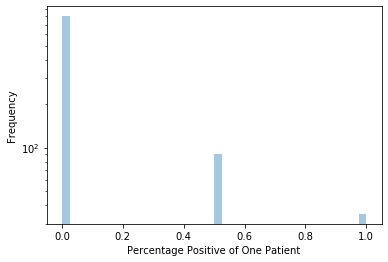

In [63]:
import seaborn as sns
figure = sns.distplot(np.array(out), bins=40, kde=False, rug=False).set_yscale('log')
plt.xlabel("Percentage Positive of One Patient")
plt.ylabel("Frequency")
plt.show()

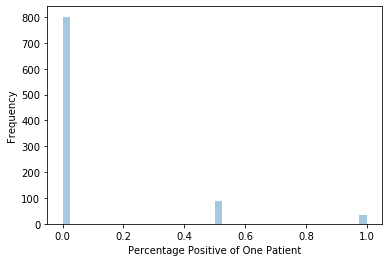

In [64]:
import seaborn as sns
figure = sns.distplot(np.array(out), bins=40, kde=False, rug=False)
plt.xlabel("Percentage Positive of One Patient")
plt.ylabel("Frequency")
plt.show()